In [ ]:
# Import the required libraries

from numpy import zeros, ones
from numpy.random import randn, randint

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Discriminator architecture

def define_discriminator(in_shape=(128,128,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 64x64
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 32x32
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 16x16
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 8x8
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       1

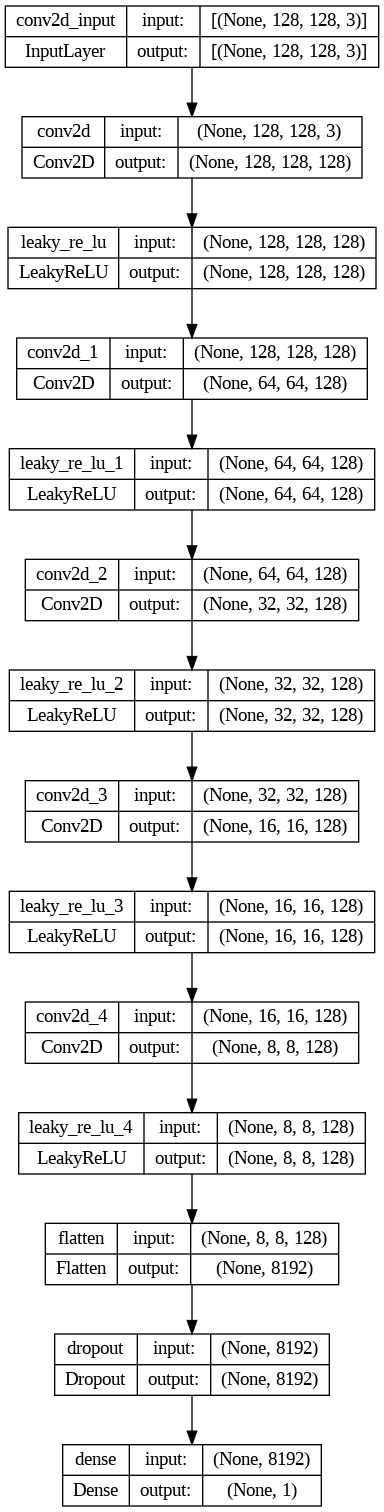

In [ ]:
#Verify the model summary
test_discr = define_discriminator()
print(test_discr.summary())
plot_model(test_discr, to_file='disc_model.png', show_shapes=True)

In [ ]:
# Discriminator architecture

def define_generator(latent_dim):
	model = Sequential()
	# Define number of nodes that can be gradually reshaped and upscaled to 128x128x3
	n_nodes = 128 * 8 * 8 #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 128x128x3
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #tanh goes from [-1,1]
	return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

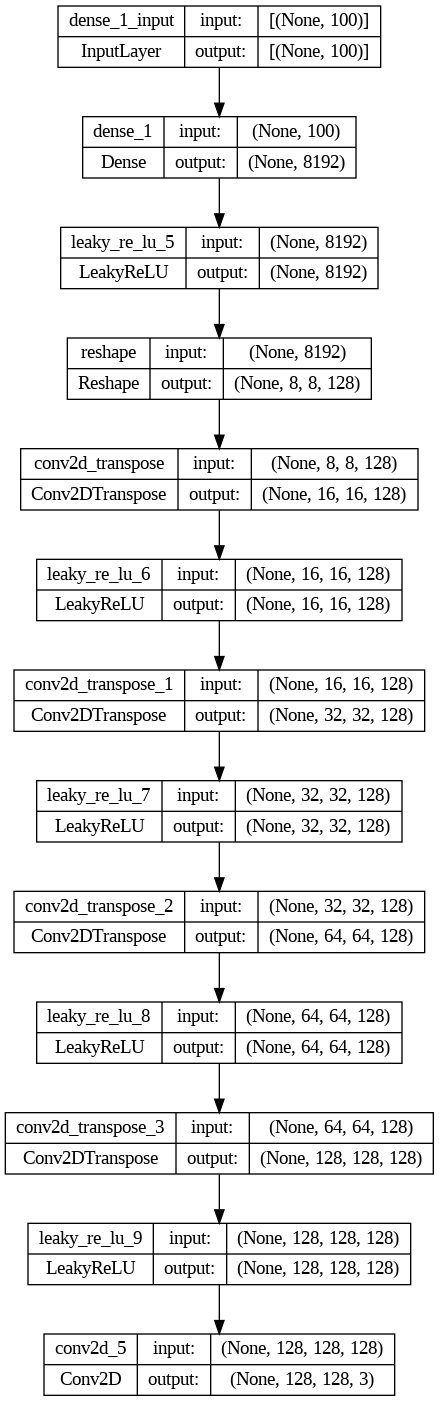

In [ ]:
test_gen = define_generator(100)
print(test_gen.summary())
plot_model(test_gen, to_file='generator_model.png', show_shapes=True)

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       1901059   
                                                                 
 sequential (Sequential)     (None, 1)                 602113    
                                                                 
Total params: 2,503,172
Trainable params: 1,901,059
Non-trainable params: 602,113
_________________________________________________________________
None


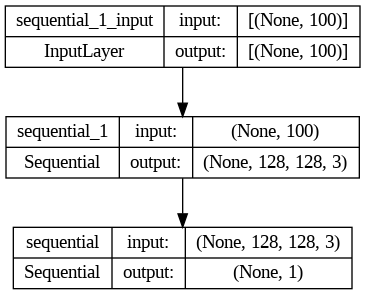

In [ ]:
test_gan = define_gan(test_gen, test_discr)
print(test_gan.summary())
plot_model(test_gan, to_file='combined_model.png', show_shapes=True)

In [ ]:
# Function to sample some random real images
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1)) # Class labels for real images are 1
	return X, y

In [ ]:
# Function to generate random latent points
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator.
	return x_input

In [ ]:
# Function to generate fake images using latent vectors
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples) #Generate latent points as input to the generator
	X = g_model.predict(x_input) #Use the generator to generate fake images
	y = zeros((n_samples, 1)) # Class labels for fake images are 0
	return X, y

In [ ]:
# Function to save Plots after every n number of epochs
def save_plot(examples, epoch, n=10):
	# scale images from [-1,1] to [0,1] so we can plot
	examples = (examples + 1) / 2.0
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i])
	# save plot to a file so we can view how generated images evolved over epochs
	filename = '/content/drive/MyDrive/exp gan/generated/generated_plot_128x128_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [ ]:
# Function to summarize performance periodically.
#
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# Fetch real images
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real images - get accuracy
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# Generate fake images
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake images - get accuracy
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# Print discriminate accuracies on ral and fake images.
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save generated images periodically using the save_plot function
	save_plot(x_fake, epoch)
	# save the generator model
	filename = '/content/drive/MyDrive/exp gan/models/generator_model_128x128_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [ ]:
# train the generator and discriminator by enumerating batches and epochs.

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2) #Disc. trained on half batch real and half batch fake images
	#  enumerate epochs
	for i in range(n_epochs):
		# enumerate batches
		for j in range(bat_per_epo):
			# Fetch random 'real' images
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# Train the discriminator using real images
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' images
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# Train the discriminator using fake images
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# Generate latent vectors as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# Label generated (fake) mages as 1 to fool the discriminator
			y_gan = ones((n_batch, 1))
			# Train the generator (via the discriminator's error)
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# Report disc. and gen losses.
			print('Epoch>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
import random


In [ ]:
n=10000 #Number of images to read from the directory. (For training)
SIZE = 128 #Resize images to this size
all_img_list = os.listdir('/content/drive/MyDrive/exp gan/Face dataset') #
dataset_list = random.sample(all_img_list, n) #Get n random images from the directory

In [ ]:
dataset_list

['1_0_0_20161219140623097 (14528).jpg',
 '1_0_0_20161219140623097 (10080).jpg',
 '1_0_0_20161219140623097 (13967).jpg',
 '1_0_0_20161219140623097 (18742).jpg',
 '1_0_0_20161219140623097 (12626).jpg',
 '1_0_0_20161219140623097 (10749).jpg',
 '1_0_0_20161219140623097 (12548).jpg',
 '1_0_0_20161219140623097 (15777).jpg',
 '1_0_0_20161219140623097 (10226).jpg',
 '1_0_0_20161219140623097 (18633).jpg',
 '1_0_0_20161219140623097 (13).jpg',
 '1_0_0_20161219140623097 (11110).jpg',
 '1_0_0_20161219140623097 (12891).jpg',
 '1_0_0_20161219140623097 (18758).jpg',
 '1_0_0_20161219140623097 (12667).jpg',
 '1_0_0_20161219140623097 (16023).jpg',
 '1_0_0_20161219140623097 (17534).jpg',
 '1_0_0_20161219140623097 (13218).jpg',
 '1_0_0_20161219140623097 (15026).jpg',
 '1_0_0_20161219140623097 (16533).jpg',
 '1_0_0_20161219140623097 (10739).jpg',
 '1_0_0_20161219140623097 (17806).jpg',
 '1_0_0_20161219140623097 (10295).jpg',
 '1_0_0_20161219140623097 (14109).jpg',
 '1_0_0_20161219140623097 (15612).jpg',
 '1

In [ ]:
# resizing the images and converting to numpy array

dataset = []
for img in dataset_list:
    img_path = "/content/drive/MyDrive/exp gan/Face dataset/" + img
    print(img_path)
    try:
        temp_img = cv2.imread(img_path)
        if temp_img is None:
            raise ValueError(f"Failed to read image: {img_path}")
        temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
        temp_img = Image.fromarray(temp_img)
        temp_img = temp_img.resize((SIZE, SIZE))
        dataset.append(np.array(temp_img))
    except Exception as e:
        print(f"Error processing image: {img_path}")
        print(e)

dataset = np.array(dataset)


Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (15916).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (16255).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (1054).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (10011).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (1158).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (15487).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (15558).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (11558).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (10053).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (15397).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (18310).jpg
/content/drive/MyDrive/exp gan/Face dataset/1_0_0_20161219140623097 (13

In [ ]:
#Rescale to [-1, 1]
dataset = dataset.astype('float32')
	# scale from [0,255] to [-1,1]
dataset = (dataset - 127.5) / 127.5

In [ ]:
dataset

array([[[[-0.77254903, -0.7411765 , -0.654902  ],
         [-0.70980394, -0.6784314 , -0.5921569 ],
         [-0.7411765 , -0.70980394, -0.6313726 ],
         ...,
         [-0.5921569 , -0.5058824 , -0.8352941 ],
         [-0.5921569 , -0.5058824 , -0.8352941 ],
         [-0.5921569 , -0.5058824 , -0.8352941 ]],

        [[-0.73333335, -0.7019608 , -0.6156863 ],
         [-0.7254902 , -0.69411767, -0.60784316],
         [-0.78039217, -0.7490196 , -0.67058825],
         ...,
         [-0.58431375, -0.49803922, -0.827451  ],
         [-0.58431375, -0.49803922, -0.827451  ],
         [-0.58431375, -0.49803922, -0.827451  ]],

        [[-0.7647059 , -0.7411765 , -0.654902  ],
         [-0.7411765 , -0.7176471 , -0.62352943],
         [-0.7647059 , -0.73333335, -0.654902  ],
         ...,
         [-0.5764706 , -0.49019608, -0.81960785],
         [-0.5764706 , -0.49019608, -0.81960785],
         [-0.5764706 , -0.49019608, -0.81960785]],

        ...,

        [[ 0.4117647 ,  0.5921569 ,  0

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator using our pre-defined function
d_model = define_discriminator()
# create the generator using our pre-defined function
g_model = define_generator(latent_dim)
# create the gan  using our pre-defined function
gan_model = define_gan(g_model, d_model)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)

2/2 [==============================] - 2s 8ms/step
Epoch>1, 1/78, d1=0.685, d2=0.707 g=0.693
2/2 [==============================] - 0s 50ms/step
Epoch>1, 2/78, d1=0.409, d2=0.751 g=0.693
2/2 [==============================] - 0s 51ms/step
Epoch>1, 3/78, d1=0.005, d2=1.298 g=0.748
2/2 [==============================] - 0s 53ms/step
Epoch>1, 4/78, d1=0.170, d2=0.680 g=0.723
2/2 [==============================] - 0s 49ms/step
Epoch>1, 5/78, d1=0.035, d2=0.761 g=0.731
2/2 [==============================] - 0s 50ms/step
Epoch>1, 6/78, d1=0.039, d2=0.686 g=0.735
2/2 [==============================] - 0s 50ms/step
Epoch>1, 7/78, d1=0.021, d2=0.658 g=0.826
2/2 [==============================] - 0s 52ms/step
Epoch>1, 8/78, d1=0.003, d2=0.777 g=1.025
2/2 [==============================] - 0s 50ms/step
Epoch>1, 9/78, d1=0.094, d2=0.431 g=1.973
2/2 [==============================] - 0s 49ms/step
Epoch>1, 10/78, d1=0.001, d2=0.084 g=6.007
2/2 [==============================] - 0s 50ms/step
Epoch>1,

2/2 [==============================] - 0s 54ms/step
Epoch>2, 1/78, d1=0.054, d2=0.099 g=4.267
2/2 [==============================] - 0s 50ms/step
Epoch>2, 2/78, d1=0.031, d2=0.080 g=4.009
2/2 [==============================] - 0s 49ms/step
Epoch>2, 3/78, d1=0.059, d2=0.430 g=3.505
2/2 [==============================] - 0s 53ms/step
Epoch>2, 4/78, d1=0.054, d2=0.458 g=14.447
2/2 [==============================] - 0s 49ms/step
Epoch>2, 5/78, d1=1.492, d2=0.162 g=2.149
2/2 [==============================] - 0s 50ms/step
Epoch>2, 6/78, d1=0.133, d2=0.167 g=2.554
2/2 [==============================] - 0s 53ms/step
Epoch>2, 7/78, d1=0.058, d2=1.176 g=3.760
2/2 [==============================] - 0s 50ms/step
Epoch>2, 8/78, d1=0.236, d2=0.270 g=5.014
2/2 [==============================] - 0s 52ms/step
Epoch>2, 9/78, d1=0.795, d2=0.603 g=2.048
2/2 [==============================] - 0s 50ms/step
Epoch>2, 10/78, d1=0.225, d2=0.313 g=3.186
2/2 [==============================] - 0s 52ms/step
Epoch>

2/2 [==============================] - 0s 53ms/step
Epoch>3, 1/78, d1=0.903, d2=0.686 g=1.143
2/2 [==============================] - 0s 50ms/step
Epoch>3, 2/78, d1=0.596, d2=0.591 g=1.533
2/2 [==============================] - 0s 51ms/step
Epoch>3, 3/78, d1=0.450, d2=0.365 g=2.013
2/2 [==============================] - 0s 50ms/step
Epoch>3, 4/78, d1=0.429, d2=0.358 g=2.337
2/2 [==============================] - 0s 50ms/step
Epoch>3, 5/78, d1=0.494, d2=0.662 g=2.214
2/2 [==============================] - 0s 52ms/step
Epoch>3, 6/78, d1=0.803, d2=0.981 g=1.133
2/2 [==============================] - 0s 50ms/step
Epoch>3, 7/78, d1=0.560, d2=0.660 g=1.272
2/2 [==============================] - 0s 49ms/step
Epoch>3, 8/78, d1=0.756, d2=0.657 g=1.244
2/2 [==============================] - 0s 49ms/step
Epoch>3, 9/78, d1=0.513, d2=0.626 g=1.528
2/2 [==============================] - 0s 51ms/step
Epoch>3, 10/78, d1=0.593, d2=0.410 g=1.847
2/2 [==============================] - 0s 49ms/step
Epoch>3

2/2 [==============================] - 0s 49ms/step
Epoch>4, 1/78, d1=0.515, d2=0.585 g=1.602
2/2 [==============================] - 0s 49ms/step
Epoch>4, 2/78, d1=0.387, d2=0.900 g=3.169
2/2 [==============================] - 0s 50ms/step
Epoch>4, 3/78, d1=0.676, d2=0.545 g=1.426
2/2 [==============================] - 0s 53ms/step
Epoch>4, 4/78, d1=0.594, d2=1.063 g=1.140
2/2 [==============================] - 0s 53ms/step
Epoch>4, 5/78, d1=0.596, d2=0.414 g=2.573
2/2 [==============================] - 0s 49ms/step
Epoch>4, 6/78, d1=0.817, d2=0.432 g=1.659
2/2 [==============================] - 0s 50ms/step
Epoch>4, 7/78, d1=0.757, d2=0.519 g=1.442
2/2 [==============================] - 0s 50ms/step
Epoch>4, 8/78, d1=0.763, d2=0.702 g=1.215
2/2 [==============================] - 0s 51ms/step
Epoch>4, 9/78, d1=0.601, d2=0.690 g=1.615
2/2 [==============================] - 0s 49ms/step
Epoch>4, 10/78, d1=0.739, d2=0.590 g=1.675
2/2 [==============================] - 0s 50ms/step
Epoch>4

2/2 [==============================] - 0s 49ms/step
Epoch>5, 1/78, d1=0.481, d2=0.843 g=1.194
2/2 [==============================] - 0s 50ms/step
Epoch>5, 2/78, d1=0.503, d2=0.742 g=1.239
2/2 [==============================] - 0s 50ms/step
Epoch>5, 3/78, d1=0.589, d2=0.869 g=1.204
2/2 [==============================] - 0s 52ms/step
Epoch>5, 4/78, d1=0.818, d2=0.813 g=0.996
2/2 [==============================] - 0s 49ms/step
Epoch>5, 5/78, d1=0.776, d2=0.710 g=0.971
2/2 [==============================] - 0s 49ms/step
Epoch>5, 6/78, d1=0.743, d2=0.565 g=1.205
2/2 [==============================] - 0s 52ms/step
Epoch>5, 7/78, d1=0.675, d2=0.492 g=1.436
2/2 [==============================] - 0s 50ms/step
Epoch>5, 8/78, d1=0.665, d2=0.660 g=1.269
2/2 [==============================] - 0s 53ms/step
Epoch>5, 9/78, d1=0.815, d2=0.680 g=1.101
2/2 [==============================] - 0s 53ms/step
Epoch>5, 10/78, d1=0.640, d2=0.503 g=1.231
2/2 [==============================] - 0s 49ms/step
Epoch>5

2/2 [==============================] - 0s 50ms/step
Epoch>6, 1/78, d1=0.854, d2=0.735 g=1.110
2/2 [==============================] - 0s 50ms/step
Epoch>6, 2/78, d1=0.766, d2=0.803 g=0.905
2/2 [==============================] - 0s 50ms/step
Epoch>6, 3/78, d1=0.678, d2=0.699 g=1.041
2/2 [==============================] - 0s 50ms/step
Epoch>6, 4/78, d1=0.566, d2=0.535 g=1.271
2/2 [==============================] - 0s 54ms/step
Epoch>6, 5/78, d1=0.633, d2=0.477 g=1.383
2/2 [==============================] - 0s 51ms/step
Epoch>6, 6/78, d1=0.522, d2=0.466 g=1.642
2/2 [==============================] - 0s 50ms/step
Epoch>6, 7/78, d1=0.463, d2=0.397 g=2.006
2/2 [==============================] - 0s 50ms/step
Epoch>6, 8/78, d1=0.579, d2=0.762 g=1.199
2/2 [==============================] - 0s 49ms/step
Epoch>6, 9/78, d1=0.466, d2=0.818 g=1.094
2/2 [==============================] - 0s 52ms/step
Epoch>6, 10/78, d1=0.483, d2=0.630 g=1.269
2/2 [==============================] - 0s 49ms/step
Epoch>6

2/2 [==============================] - 0s 52ms/step
Epoch>7, 1/78, d1=0.553, d2=1.078 g=1.518
2/2 [==============================] - 0s 50ms/step
Epoch>7, 2/78, d1=0.788, d2=0.512 g=1.414
2/2 [==============================] - 0s 49ms/step
Epoch>7, 3/78, d1=0.537, d2=0.715 g=1.260
2/2 [==============================] - 0s 50ms/step
Epoch>7, 4/78, d1=0.674, d2=0.906 g=1.202
2/2 [==============================] - 0s 51ms/step
Epoch>7, 5/78, d1=0.742, d2=0.614 g=1.531
2/2 [==============================] - 0s 50ms/step
Epoch>7, 6/78, d1=0.650, d2=0.468 g=1.853
2/2 [==============================] - 0s 50ms/step
Epoch>7, 7/78, d1=0.643, d2=0.652 g=1.716
2/2 [==============================] - 0s 49ms/step
Epoch>7, 8/78, d1=0.649, d2=0.771 g=1.499
2/2 [==============================] - 0s 55ms/step
Epoch>7, 9/78, d1=0.615, d2=0.448 g=1.583
2/2 [==============================] - 0s 52ms/step
Epoch>7, 10/78, d1=0.526, d2=0.500 g=1.529
2/2 [==============================] - 0s 47ms/step
Epoch>7

2/2 [==============================] - 0s 53ms/step
Epoch>8, 1/78, d1=0.575, d2=0.704 g=1.387
2/2 [==============================] - 0s 50ms/step
Epoch>8, 2/78, d1=0.500, d2=0.623 g=1.497
2/2 [==============================] - 0s 49ms/step
Epoch>8, 3/78, d1=0.650, d2=0.687 g=1.368
2/2 [==============================] - 0s 55ms/step
Epoch>8, 4/78, d1=0.604, d2=0.690 g=1.377
2/2 [==============================] - 0s 49ms/step
Epoch>8, 5/78, d1=0.528, d2=0.810 g=1.475
2/2 [==============================] - 0s 49ms/step
Epoch>8, 6/78, d1=0.770, d2=0.774 g=1.208
2/2 [==============================] - 0s 50ms/step
Epoch>8, 7/78, d1=0.692, d2=0.694 g=1.124
2/2 [==============================] - 0s 50ms/step
Epoch>8, 8/78, d1=0.699, d2=0.648 g=1.164
2/2 [==============================] - 0s 50ms/step
Epoch>8, 9/78, d1=0.607, d2=0.670 g=1.238
2/2 [==============================] - 0s 50ms/step
Epoch>8, 10/78, d1=0.641, d2=0.784 g=1.093
2/2 [==============================] - 0s 49ms/step
Epoch>8

2/2 [==============================] - 0s 55ms/step
Epoch>9, 1/78, d1=0.795, d2=0.687 g=1.403
2/2 [==============================] - 0s 50ms/step
Epoch>9, 2/78, d1=0.665, d2=0.552 g=1.719
2/2 [==============================] - 0s 51ms/step
Epoch>9, 3/78, d1=0.615, d2=0.660 g=1.933
2/2 [==============================] - 0s 51ms/step
Epoch>9, 4/78, d1=0.683, d2=0.544 g=1.952
2/2 [==============================] - 0s 49ms/step
Epoch>9, 5/78, d1=0.763, d2=0.503 g=1.551
2/2 [==============================] - 0s 50ms/step
Epoch>9, 6/78, d1=0.558, d2=0.506 g=1.831
2/2 [==============================] - 0s 50ms/step
Epoch>9, 7/78, d1=0.557, d2=0.627 g=1.768
2/2 [==============================] - 0s 49ms/step
Epoch>9, 8/78, d1=0.525, d2=0.623 g=1.797
2/2 [==============================] - 0s 50ms/step
Epoch>9, 9/78, d1=0.521, d2=0.663 g=1.702
2/2 [==============================] - 0s 49ms/step
Epoch>9, 10/78, d1=0.604, d2=1.421 g=2.076
2/2 [==============================] - 0s 53ms/step
Epoch>9

2/2 [==============================] - 0s 50ms/step
Epoch>10, 1/78, d1=0.564, d2=0.770 g=1.348
2/2 [==============================] - 0s 50ms/step
Epoch>10, 2/78, d1=0.550, d2=0.712 g=1.545
2/2 [==============================] - 0s 50ms/step
Epoch>10, 3/78, d1=0.767, d2=0.602 g=1.364
2/2 [==============================] - 0s 50ms/step
Epoch>10, 4/78, d1=0.619, d2=0.630 g=1.260
2/2 [==============================] - 0s 50ms/step
Epoch>10, 5/78, d1=0.508, d2=0.749 g=1.173
2/2 [==============================] - 0s 50ms/step
Epoch>10, 6/78, d1=0.565, d2=0.936 g=1.204
2/2 [==============================] - 0s 50ms/step
Epoch>10, 7/78, d1=0.679, d2=0.690 g=1.239
2/2 [==============================] - 0s 53ms/step
Epoch>10, 8/78, d1=0.586, d2=0.583 g=1.141
2/2 [==============================] - 0s 50ms/step
Epoch>10, 9/78, d1=0.554, d2=0.678 g=1.156
2/2 [==============================] - 0s 49ms/step
Epoch>10, 10/78, d1=0.497, d2=0.742 g=1.425
2/2 [==============================] - 0s 50ms/st

2/2 [==============================] - 0s 61ms/step
Epoch>11, 1/78, d1=0.555, d2=0.569 g=1.473
2/2 [==============================] - 0s 50ms/step
Epoch>11, 2/78, d1=0.468, d2=0.659 g=1.521
2/2 [==============================] - 0s 49ms/step
Epoch>11, 3/78, d1=0.682, d2=0.582 g=1.390
2/2 [==============================] - 0s 50ms/step
Epoch>11, 4/78, d1=0.680, d2=0.632 g=1.261
2/2 [==============================] - 0s 50ms/step
Epoch>11, 5/78, d1=0.476, d2=0.674 g=1.232
2/2 [==============================] - 0s 50ms/step
Epoch>11, 6/78, d1=0.487, d2=0.680 g=1.264
2/2 [==============================] - 0s 49ms/step
Epoch>11, 7/78, d1=0.504, d2=0.630 g=1.290
2/2 [==============================] - 0s 50ms/step
Epoch>11, 8/78, d1=0.749, d2=0.970 g=1.215
2/2 [==============================] - 0s 53ms/step
Epoch>11, 9/78, d1=0.620, d2=1.242 g=1.455
2/2 [==============================] - 0s 52ms/step
Epoch>11, 10/78, d1=0.845, d2=0.485 g=1.346
2/2 [==============================] - 0s 53ms/st

2/2 [==============================] - 0s 62ms/step
Epoch>12, 1/78, d1=0.498, d2=0.900 g=1.199
2/2 [==============================] - 0s 50ms/step
Epoch>12, 2/78, d1=0.672, d2=0.688 g=1.230
2/2 [==============================] - 0s 51ms/step
Epoch>12, 3/78, d1=0.627, d2=0.613 g=1.212
2/2 [==============================] - 0s 51ms/step
Epoch>12, 4/78, d1=0.594, d2=0.977 g=1.495
2/2 [==============================] - 0s 50ms/step
Epoch>12, 5/78, d1=0.797, d2=0.512 g=1.648
2/2 [==============================] - 0s 50ms/step
Epoch>12, 6/78, d1=0.797, d2=1.134 g=1.442
2/2 [==============================] - 0s 51ms/step
Epoch>12, 7/78, d1=0.882, d2=0.533 g=1.136
2/2 [==============================] - 0s 52ms/step
Epoch>12, 8/78, d1=0.801, d2=0.659 g=1.037
2/2 [==============================] - 0s 51ms/step
Epoch>12, 9/78, d1=0.693, d2=0.699 g=1.106
2/2 [==============================] - 0s 52ms/step
Epoch>12, 10/78, d1=0.628, d2=0.602 g=1.192
2/2 [==============================] - 0s 50ms/st

2/2 [==============================] - 0s 53ms/step
Epoch>13, 1/78, d1=0.559, d2=0.653 g=1.316
2/2 [==============================] - 0s 50ms/step
Epoch>13, 2/78, d1=0.633, d2=0.692 g=1.417
2/2 [==============================] - 0s 50ms/step
Epoch>13, 3/78, d1=0.660, d2=0.663 g=1.368
2/2 [==============================] - 0s 54ms/step
Epoch>13, 4/78, d1=0.815, d2=0.687 g=1.329
2/2 [==============================] - 0s 50ms/step
Epoch>13, 5/78, d1=0.760, d2=0.682 g=1.156
2/2 [==============================] - 0s 51ms/step
Epoch>13, 6/78, d1=0.583, d2=0.685 g=1.219
2/2 [==============================] - 0s 50ms/step
Epoch>13, 7/78, d1=0.583, d2=1.067 g=1.369
2/2 [==============================] - 0s 49ms/step
Epoch>13, 8/78, d1=0.692, d2=0.537 g=1.284
2/2 [==============================] - 0s 50ms/step
Epoch>13, 9/78, d1=0.660, d2=0.489 g=1.201
2/2 [==============================] - 0s 50ms/step
Epoch>13, 10/78, d1=0.544, d2=0.705 g=1.032
2/2 [==============================] - 0s 50ms/st

2/2 [==============================] - 0s 50ms/step
Epoch>14, 1/78, d1=0.750, d2=0.635 g=1.016
2/2 [==============================] - 0s 49ms/step
Epoch>14, 2/78, d1=0.651, d2=0.656 g=1.025
2/2 [==============================] - 0s 50ms/step
Epoch>14, 3/78, d1=0.614, d2=0.659 g=1.148
2/2 [==============================] - 0s 49ms/step
Epoch>14, 4/78, d1=0.568, d2=0.639 g=1.180
2/2 [==============================] - 0s 50ms/step
Epoch>14, 5/78, d1=0.617, d2=0.623 g=1.142
2/2 [==============================] - 0s 50ms/step
Epoch>14, 6/78, d1=0.593, d2=0.755 g=1.081
2/2 [==============================] - 0s 49ms/step
Epoch>14, 7/78, d1=0.636, d2=0.766 g=1.082
2/2 [==============================] - 0s 50ms/step
Epoch>14, 8/78, d1=0.748, d2=0.699 g=1.084
2/2 [==============================] - 0s 49ms/step
Epoch>14, 9/78, d1=0.812, d2=0.746 g=1.000
2/2 [==============================] - 0s 53ms/step
Epoch>14, 10/78, d1=0.761, d2=0.685 g=1.073
2/2 [==============================] - 0s 53ms/st

2/2 [==============================] - 0s 56ms/step
Epoch>15, 1/78, d1=0.688, d2=0.625 g=1.014
2/2 [==============================] - 0s 50ms/step
Epoch>15, 2/78, d1=0.578, d2=0.633 g=1.085
2/2 [==============================] - 0s 52ms/step
Epoch>15, 3/78, d1=0.585, d2=0.689 g=1.095
2/2 [==============================] - 0s 50ms/step
Epoch>15, 4/78, d1=0.499, d2=0.669 g=1.203
2/2 [==============================] - 0s 50ms/step
Epoch>15, 5/78, d1=0.504, d2=0.647 g=1.122
2/2 [==============================] - 0s 50ms/step
Epoch>15, 6/78, d1=0.709, d2=0.759 g=1.128
2/2 [==============================] - 0s 50ms/step
Epoch>15, 7/78, d1=0.676, d2=0.564 g=1.159
2/2 [==============================] - 0s 50ms/step
Epoch>15, 8/78, d1=0.671, d2=0.656 g=1.044
2/2 [==============================] - 0s 49ms/step
Epoch>15, 9/78, d1=0.482, d2=0.711 g=1.092
2/2 [==============================] - 0s 52ms/step
Epoch>15, 10/78, d1=0.579, d2=0.772 g=1.228
2/2 [==============================] - 0s 50ms/st

2/2 [==============================] - 0s 52ms/step
Epoch>16, 1/78, d1=0.718, d2=0.633 g=1.049
2/2 [==============================] - 0s 54ms/step
Epoch>16, 2/78, d1=0.626, d2=0.735 g=1.104
2/2 [==============================] - 0s 53ms/step
Epoch>16, 3/78, d1=0.695, d2=0.620 g=1.076
2/2 [==============================] - 0s 49ms/step
Epoch>16, 4/78, d1=0.615, d2=0.664 g=1.110
2/2 [==============================] - 0s 50ms/step
Epoch>16, 5/78, d1=0.598, d2=0.720 g=1.283
2/2 [==============================] - 0s 50ms/step
Epoch>16, 6/78, d1=0.670, d2=0.575 g=1.280
2/2 [==============================] - 0s 50ms/step
Epoch>16, 7/78, d1=0.668, d2=0.538 g=1.281
2/2 [==============================] - 0s 51ms/step
Epoch>16, 8/78, d1=0.639, d2=0.588 g=1.151
2/2 [==============================] - 0s 50ms/step
Epoch>16, 9/78, d1=0.584, d2=0.653 g=1.159
2/2 [==============================] - 0s 49ms/step
Epoch>16, 10/78, d1=0.663, d2=0.632 g=1.098
2/2 [==============================] - 0s 50ms/st

2/2 [==============================] - 0s 50ms/step
Epoch>17, 1/78, d1=436.484, d2=0.000 g=1564.094
2/2 [==============================] - 0s 50ms/step
Epoch>17, 2/78, d1=200.441, d2=0.000 g=1633.215
2/2 [==============================] - 0s 50ms/step
Epoch>17, 3/78, d1=305.381, d2=0.000 g=1198.773
2/2 [==============================] - 0s 50ms/step
Epoch>17, 4/78, d1=372.164, d2=0.000 g=1101.861
2/2 [==============================] - 0s 49ms/step
Epoch>17, 5/78, d1=2.203, d2=0.000 g=1084.901
2/2 [==============================] - 0s 49ms/step
Epoch>17, 6/78, d1=0.088, d2=0.000 g=1037.018
2/2 [==============================] - 0s 49ms/step
Epoch>17, 7/78, d1=0.042, d2=0.000 g=973.918
2/2 [==============================] - 0s 50ms/step
Epoch>17, 8/78, d1=45.646, d2=0.000 g=969.495
2/2 [==============================] - 0s 52ms/step
Epoch>17, 9/78, d1=0.000, d2=0.000 g=964.887
2/2 [==============================] - 0s 50ms/step
Epoch>17, 10/78, d1=16.759, d2=0.000 g=982.881
2/2 [========

2/2 [==============================] - 0s 55ms/step
Epoch>18, 1/78, d1=7.844, d2=1.609 g=3008.374
2/2 [==============================] - 0s 50ms/step
Epoch>18, 2/78, d1=1.735, d2=0.000 g=2919.767
2/2 [==============================] - 0s 50ms/step
Epoch>18, 3/78, d1=4.903, d2=5.443 g=3051.740
2/2 [==============================] - 0s 50ms/step
Epoch>18, 4/78, d1=4.602, d2=0.000 g=2992.329
2/2 [==============================] - 0s 50ms/step
Epoch>18, 5/78, d1=2.011, d2=0.000 g=2845.885
2/2 [==============================] - 0s 49ms/step
Epoch>18, 6/78, d1=0.000, d2=2.120 g=2949.659
2/2 [==============================] - 0s 49ms/step
Epoch>18, 7/78, d1=2.727, d2=7.026 g=3012.992
2/2 [==============================] - 0s 50ms/step
Epoch>18, 8/78, d1=0.606, d2=7.657 g=3435.463
2/2 [==============================] - 0s 53ms/step
Epoch>18, 9/78, d1=12.636, d2=0.000 g=2800.728
2/2 [==============================] - 0s 51ms/step
Epoch>18, 10/78, d1=18.004, d2=1.898 g=2493.486
2/2 [============

2/2 [==============================] - 0s 51ms/step
Epoch>19, 1/78, d1=3.980, d2=0.000 g=1373.382
2/2 [==============================] - 0s 50ms/step
Epoch>19, 2/78, d1=0.206, d2=1.049 g=1607.425
2/2 [==============================] - 0s 50ms/step
Epoch>19, 3/78, d1=0.000, d2=2.321 g=1502.781
2/2 [==============================] - 0s 50ms/step
Epoch>19, 4/78, d1=0.000, d2=0.000 g=1733.349
2/2 [==============================] - 0s 50ms/step
Epoch>19, 5/78, d1=0.000, d2=0.000 g=1675.933
2/2 [==============================] - 0s 52ms/step
Epoch>19, 6/78, d1=0.000, d2=0.000 g=1731.546
2/2 [==============================] - 0s 50ms/step
Epoch>19, 7/78, d1=0.000, d2=0.000 g=1604.334
2/2 [==============================] - 0s 49ms/step
Epoch>19, 8/78, d1=0.000, d2=0.000 g=1670.476
2/2 [==============================] - 0s 49ms/step
Epoch>19, 9/78, d1=2.328, d2=0.000 g=1710.975
2/2 [==============================] - 0s 57ms/step
Epoch>19, 10/78, d1=9.333, d2=0.000 g=1282.721
2/2 [==============

2/2 [==============================] - 0s 50ms/step
Epoch>20, 1/78, d1=0.000, d2=0.000 g=946.436
2/2 [==============================] - 0s 50ms/step
Epoch>20, 2/78, d1=0.000, d2=0.000 g=927.882
2/2 [==============================] - 0s 49ms/step
Epoch>20, 3/78, d1=0.045, d2=0.000 g=787.327
2/2 [==============================] - 0s 50ms/step
Epoch>20, 4/78, d1=0.000, d2=0.000 g=777.234
2/2 [==============================] - 0s 50ms/step
Epoch>20, 5/78, d1=0.000, d2=0.000 g=750.097
2/2 [==============================] - 0s 50ms/step
Epoch>20, 6/78, d1=3.908, d2=0.000 g=538.708
2/2 [==============================] - 0s 49ms/step
Epoch>20, 7/78, d1=0.000, d2=0.000 g=492.839
2/2 [==============================] - 0s 50ms/step
Epoch>20, 8/78, d1=0.000, d2=0.000 g=484.658
2/2 [==============================] - 0s 52ms/step
Epoch>20, 9/78, d1=4.541, d2=0.000 g=433.773
2/2 [==============================] - 0s 50ms/step
Epoch>20, 10/78, d1=0.000, d2=0.000 g=428.781
2/2 [========================

2/2 [==============================] - 0s 50ms/step
Epoch>21, 1/78, d1=0.000, d2=0.000 g=824.145
2/2 [==============================] - 0s 49ms/step
Epoch>21, 2/78, d1=0.000, d2=0.000 g=833.360
2/2 [==============================] - 0s 49ms/step
Epoch>21, 3/78, d1=0.000, d2=0.000 g=835.036
2/2 [==============================] - 0s 50ms/step
Epoch>21, 4/78, d1=0.000, d2=0.000 g=833.975
2/2 [==============================] - 0s 50ms/step
Epoch>21, 5/78, d1=0.003, d2=0.000 g=782.878
2/2 [==============================] - 0s 49ms/step
Epoch>21, 6/78, d1=0.000, d2=0.000 g=828.389
2/2 [==============================] - 0s 50ms/step
Epoch>21, 7/78, d1=0.000, d2=0.000 g=811.191
2/2 [==============================] - 0s 50ms/step
Epoch>21, 8/78, d1=2.142, d2=0.000 g=776.783
2/2 [==============================] - 0s 49ms/step
Epoch>21, 9/78, d1=0.000, d2=0.000 g=794.132
2/2 [==============================] - 0s 50ms/step
Epoch>21, 10/78, d1=0.000, d2=0.000 g=783.687
2/2 [========================

2/2 [==============================] - 0s 47ms/step
Epoch>22, 1/78, d1=1.743, d2=0.000 g=423.411
2/2 [==============================] - 0s 50ms/step
Epoch>22, 2/78, d1=0.000, d2=0.286 g=586.430
2/2 [==============================] - 0s 49ms/step
Epoch>22, 3/78, d1=0.000, d2=0.000 g=741.815
2/2 [==============================] - 0s 50ms/step
Epoch>22, 4/78, d1=0.000, d2=0.000 g=801.506
2/2 [==============================] - 0s 51ms/step
Epoch>22, 5/78, d1=0.000, d2=0.000 g=818.204
2/2 [==============================] - 0s 50ms/step
Epoch>22, 6/78, d1=0.000, d2=0.000 g=790.744
2/2 [==============================] - 0s 50ms/step
Epoch>22, 7/78, d1=0.000, d2=0.000 g=821.531
2/2 [==============================] - 0s 51ms/step
Epoch>22, 8/78, d1=0.000, d2=0.000 g=812.277
2/2 [==============================] - 0s 49ms/step
Epoch>22, 9/78, d1=0.000, d2=0.000 g=812.306
2/2 [==============================] - 0s 50ms/step
Epoch>22, 10/78, d1=0.000, d2=0.000 g=801.342
2/2 [========================

2/2 [==============================] - 0s 50ms/step
Epoch>23, 1/78, d1=0.000, d2=0.000 g=721.725
2/2 [==============================] - 0s 53ms/step
Epoch>23, 2/78, d1=0.000, d2=0.000 g=716.292
2/2 [==============================] - 0s 50ms/step
Epoch>23, 3/78, d1=0.000, d2=1.799 g=1067.480
2/2 [==============================] - 0s 50ms/step
Epoch>23, 4/78, d1=7.903, d2=0.000 g=894.229
2/2 [==============================] - 0s 50ms/step
Epoch>23, 5/78, d1=0.000, d2=0.000 g=845.701
2/2 [==============================] - 0s 50ms/step
Epoch>23, 6/78, d1=0.000, d2=0.000 g=770.517
2/2 [==============================] - 0s 50ms/step
Epoch>23, 7/78, d1=0.000, d2=0.000 g=793.889
2/2 [==============================] - 0s 49ms/step
Epoch>23, 8/78, d1=2.312, d2=0.000 g=808.156
2/2 [==============================] - 0s 50ms/step
Epoch>23, 9/78, d1=0.000, d2=0.000 g=723.539
2/2 [==============================] - 0s 50ms/step
Epoch>23, 10/78, d1=0.000, d2=0.000 g=700.859
2/2 [=======================

2/2 [==============================] - 0s 63ms/step
Epoch>24, 1/78, d1=0.000, d2=0.000 g=728.820
2/2 [==============================] - 0s 50ms/step
Epoch>24, 2/78, d1=0.000, d2=0.000 g=726.572
2/2 [==============================] - 0s 50ms/step
Epoch>24, 3/78, d1=0.000, d2=0.000 g=739.055
2/2 [==============================] - 0s 50ms/step
Epoch>24, 4/78, d1=0.000, d2=0.000 g=725.851
2/2 [==============================] - 0s 50ms/step
Epoch>24, 5/78, d1=0.000, d2=0.000 g=721.817
2/2 [==============================] - 0s 49ms/step
Epoch>24, 6/78, d1=0.000, d2=0.000 g=761.967
2/2 [==============================] - 0s 49ms/step
Epoch>24, 7/78, d1=0.000, d2=0.000 g=709.474
2/2 [==============================] - 0s 54ms/step
Epoch>24, 8/78, d1=0.000, d2=0.000 g=710.113
2/2 [==============================] - 0s 49ms/step
Epoch>24, 9/78, d1=0.000, d2=0.000 g=710.446
2/2 [==============================] - 0s 50ms/step
Epoch>24, 10/78, d1=0.000, d2=0.000 g=730.648
2/2 [========================

2/2 [==============================] - 0s 50ms/step
Epoch>25, 1/78, d1=0.000, d2=0.000 g=919.727
2/2 [==============================] - 0s 50ms/step
Epoch>25, 2/78, d1=0.000, d2=0.000 g=980.751
2/2 [==============================] - 0s 50ms/step
Epoch>25, 3/78, d1=1.746, d2=0.000 g=720.767
2/2 [==============================] - 0s 49ms/step
Epoch>25, 4/78, d1=0.000, d2=0.000 g=655.064
2/2 [==============================] - 0s 49ms/step
Epoch>25, 5/78, d1=0.000, d2=0.000 g=644.820
2/2 [==============================] - 0s 50ms/step
Epoch>25, 6/78, d1=1.123, d2=0.966 g=533.533
2/2 [==============================] - 0s 50ms/step
Epoch>25, 7/78, d1=0.000, d2=0.000 g=614.887
2/2 [==============================] - 0s 50ms/step
Epoch>25, 8/78, d1=0.000, d2=0.000 g=633.237
2/2 [==============================] - 0s 50ms/step
Epoch>25, 9/78, d1=0.000, d2=0.000 g=654.176
2/2 [==============================] - 0s 50ms/step
Epoch>25, 10/78, d1=0.000, d2=0.000 g=608.911
2/2 [========================

2/2 [==============================] - 0s 50ms/step
Epoch>26, 1/78, d1=0.000, d2=0.000 g=687.573
2/2 [==============================] - 0s 54ms/step
Epoch>26, 2/78, d1=0.000, d2=0.000 g=670.180
2/2 [==============================] - 0s 49ms/step
Epoch>26, 3/78, d1=0.000, d2=0.000 g=670.952
2/2 [==============================] - 0s 50ms/step
Epoch>26, 4/78, d1=0.000, d2=0.000 g=661.081
2/2 [==============================] - 0s 50ms/step
Epoch>26, 5/78, d1=1.494, d2=0.000 g=451.688
2/2 [==============================] - 0s 52ms/step
Epoch>26, 6/78, d1=0.000, d2=0.000 g=391.192
2/2 [==============================] - 0s 50ms/step
Epoch>26, 7/78, d1=0.000, d2=0.000 g=378.523
2/2 [==============================] - 0s 55ms/step
Epoch>26, 8/78, d1=0.000, d2=0.000 g=378.676
2/2 [==============================] - 0s 50ms/step
Epoch>26, 9/78, d1=0.000, d2=0.000 g=377.718
2/2 [==============================] - 0s 49ms/step
Epoch>26, 10/78, d1=0.000, d2=0.000 g=370.203
2/2 [========================

2/2 [==============================] - 0s 50ms/step
Epoch>27, 1/78, d1=0.000, d2=0.000 g=382.204
2/2 [==============================] - 0s 49ms/step
Epoch>27, 2/78, d1=0.000, d2=0.000 g=366.611
2/2 [==============================] - 0s 50ms/step
Epoch>27, 3/78, d1=0.000, d2=0.000 g=389.600
2/2 [==============================] - 0s 50ms/step
Epoch>27, 4/78, d1=0.000, d2=0.000 g=385.120
2/2 [==============================] - 0s 50ms/step
Epoch>27, 5/78, d1=0.000, d2=0.000 g=384.319
2/2 [==============================] - 0s 50ms/step
Epoch>27, 6/78, d1=0.000, d2=0.000 g=383.362
2/2 [==============================] - 0s 50ms/step
Epoch>27, 7/78, d1=0.000, d2=0.000 g=388.491
2/2 [==============================] - 0s 49ms/step
Epoch>27, 8/78, d1=0.000, d2=0.000 g=378.473
2/2 [==============================] - 0s 50ms/step
Epoch>27, 9/78, d1=0.000, d2=0.000 g=397.461
2/2 [==============================] - 0s 50ms/step
Epoch>27, 10/78, d1=0.000, d2=0.000 g=382.867
2/2 [========================

2/2 [==============================] - 0s 54ms/step
Epoch>28, 1/78, d1=0.000, d2=0.000 g=291.088
2/2 [==============================] - 0s 50ms/step
Epoch>28, 2/78, d1=0.000, d2=0.000 g=293.488
2/2 [==============================] - 0s 50ms/step
Epoch>28, 3/78, d1=0.000, d2=0.000 g=297.638
2/2 [==============================] - 0s 50ms/step
Epoch>28, 4/78, d1=0.000, d2=0.000 g=294.452
2/2 [==============================] - 0s 49ms/step
Epoch>28, 5/78, d1=0.000, d2=0.000 g=287.601
2/2 [==============================] - 0s 49ms/step
Epoch>28, 6/78, d1=0.000, d2=0.000 g=286.273
2/2 [==============================] - 0s 50ms/step
Epoch>28, 7/78, d1=0.000, d2=0.000 g=292.981
2/2 [==============================] - 0s 50ms/step
Epoch>28, 8/78, d1=0.000, d2=0.000 g=280.512
2/2 [==============================] - 0s 50ms/step
Epoch>28, 9/78, d1=0.000, d2=0.000 g=289.528
2/2 [==============================] - 0s 50ms/step
Epoch>28, 10/78, d1=0.000, d2=0.000 g=291.706
2/2 [========================

2/2 [==============================] - 0s 50ms/step
Epoch>29, 1/78, d1=0.000, d2=0.000 g=448.377
2/2 [==============================] - 0s 52ms/step
Epoch>29, 2/78, d1=0.000, d2=0.000 g=438.098
2/2 [==============================] - 0s 44ms/step
Epoch>29, 3/78, d1=0.000, d2=0.000 g=450.336
2/2 [==============================] - 0s 50ms/step
Epoch>29, 4/78, d1=0.000, d2=0.000 g=429.880
2/2 [==============================] - 0s 50ms/step
Epoch>29, 5/78, d1=0.000, d2=0.000 g=428.694
2/2 [==============================] - 0s 50ms/step
Epoch>29, 6/78, d1=0.000, d2=0.000 g=447.235
2/2 [==============================] - 0s 50ms/step
Epoch>29, 7/78, d1=0.000, d2=0.000 g=425.226
2/2 [==============================] - 0s 50ms/step
Epoch>29, 8/78, d1=0.000, d2=0.000 g=441.229
2/2 [==============================] - 0s 49ms/step
Epoch>29, 9/78, d1=0.000, d2=0.000 g=437.525
2/2 [==============================] - 0s 50ms/step
Epoch>29, 10/78, d1=2.308, d2=0.000 g=327.548
2/2 [========================

2/2 [==============================] - 0s 51ms/step
Epoch>30, 1/78, d1=0.000, d2=0.000 g=431.296
2/2 [==============================] - 0s 53ms/step
Epoch>30, 2/78, d1=0.000, d2=0.000 g=408.987
2/2 [==============================] - 0s 50ms/step
Epoch>30, 3/78, d1=0.000, d2=0.000 g=421.833
2/2 [==============================] - 0s 51ms/step
Epoch>30, 4/78, d1=0.000, d2=0.000 g=403.287
2/2 [==============================] - 0s 50ms/step
Epoch>30, 5/78, d1=0.000, d2=0.000 g=401.479
2/2 [==============================] - 0s 50ms/step
Epoch>30, 6/78, d1=0.000, d2=0.000 g=412.261
2/2 [==============================] - 0s 50ms/step
Epoch>30, 7/78, d1=0.000, d2=0.000 g=409.576
2/2 [==============================] - 0s 50ms/step
Epoch>30, 8/78, d1=0.000, d2=0.000 g=395.550
2/2 [==============================] - 0s 53ms/step
Epoch>30, 9/78, d1=0.000, d2=0.000 g=409.275
2/2 [==============================] - 0s 49ms/step
Epoch>30, 10/78, d1=0.000, d2=0.000 g=412.090
2/2 [========================

2/2 [==============================] - 0s 52ms/step
Epoch>31, 1/78, d1=0.000, d2=0.596 g=1594.616
2/2 [==============================] - 0s 50ms/step
Epoch>31, 2/78, d1=2.325, d2=0.000 g=1459.937
2/2 [==============================] - 0s 50ms/step
Epoch>31, 3/78, d1=0.892, d2=0.000 g=690.203
2/2 [==============================] - 0s 50ms/step
Epoch>31, 4/78, d1=0.000, d2=2.489 g=1307.433
2/2 [==============================] - 0s 50ms/step
Epoch>31, 5/78, d1=0.000, d2=0.000 g=1871.997
2/2 [==============================] - 0s 50ms/step
Epoch>31, 6/78, d1=0.000, d2=0.000 g=2040.152
2/2 [==============================] - 0s 50ms/step
Epoch>31, 7/78, d1=0.000, d2=0.000 g=2064.622
2/2 [==============================] - 0s 50ms/step
Epoch>31, 8/78, d1=0.000, d2=0.000 g=2051.628
2/2 [==============================] - 0s 52ms/step
Epoch>31, 9/78, d1=0.751, d2=0.000 g=1344.905
2/2 [==============================] - 0s 50ms/step
Epoch>31, 10/78, d1=0.000, d2=0.000 g=1133.114
2/2 [===============

2/2 [==============================] - 0s 50ms/step
Epoch>32, 1/78, d1=0.000, d2=0.000 g=895.421
2/2 [==============================] - 0s 50ms/step
Epoch>32, 2/78, d1=0.000, d2=0.000 g=873.324
2/2 [==============================] - 0s 50ms/step
Epoch>32, 3/78, d1=0.000, d2=0.000 g=893.963
2/2 [==============================] - 0s 50ms/step
Epoch>32, 4/78, d1=5.336, d2=0.000 g=538.955
2/2 [==============================] - 0s 49ms/step
Epoch>32, 5/78, d1=0.000, d2=0.000 g=450.031
2/2 [==============================] - 0s 49ms/step
Epoch>32, 6/78, d1=0.000, d2=0.000 g=409.616
2/2 [==============================] - 0s 50ms/step
Epoch>32, 7/78, d1=0.000, d2=0.000 g=405.952
2/2 [==============================] - 0s 49ms/step
Epoch>32, 8/78, d1=0.000, d2=0.000 g=368.113
2/2 [==============================] - 0s 50ms/step
Epoch>32, 9/78, d1=0.000, d2=0.000 g=378.834
2/2 [==============================] - 0s 58ms/step
Epoch>32, 10/78, d1=0.000, d2=0.000 g=379.816
2/2 [========================

2/2 [==============================] - 0s 54ms/step
Epoch>33, 1/78, d1=0.000, d2=0.000 g=473.688
2/2 [==============================] - 0s 49ms/step
Epoch>33, 2/78, d1=0.000, d2=0.000 g=473.521
2/2 [==============================] - 0s 50ms/step
Epoch>33, 3/78, d1=0.000, d2=0.000 g=477.408
2/2 [==============================] - 0s 49ms/step
Epoch>33, 4/78, d1=0.000, d2=0.000 g=479.718
2/2 [==============================] - 0s 49ms/step
Epoch>33, 5/78, d1=0.000, d2=0.000 g=467.574
2/2 [==============================] - 0s 50ms/step
Epoch>33, 6/78, d1=0.000, d2=0.000 g=465.734
2/2 [==============================] - 0s 50ms/step
Epoch>33, 7/78, d1=0.000, d2=0.000 g=465.771
2/2 [==============================] - 0s 50ms/step
Epoch>33, 8/78, d1=0.000, d2=0.000 g=471.153
2/2 [==============================] - 0s 49ms/step
Epoch>33, 9/78, d1=0.000, d2=0.000 g=467.029
2/2 [==============================] - 0s 50ms/step
Epoch>33, 10/78, d1=0.000, d2=0.000 g=483.257
2/2 [========================

2/2 [==============================] - 0s 53ms/step
Epoch>34, 1/78, d1=0.000, d2=0.000 g=558.123
2/2 [==============================] - 0s 50ms/step
Epoch>34, 2/78, d1=0.000, d2=0.000 g=559.407
2/2 [==============================] - 0s 50ms/step
Epoch>34, 3/78, d1=0.000, d2=0.000 g=541.228
2/2 [==============================] - 0s 50ms/step
Epoch>34, 4/78, d1=0.000, d2=0.000 g=549.443
2/2 [==============================] - 0s 52ms/step
Epoch>34, 5/78, d1=0.000, d2=0.000 g=542.264
2/2 [==============================] - 0s 49ms/step
Epoch>34, 6/78, d1=0.000, d2=0.000 g=549.150
2/2 [==============================] - 0s 49ms/step
Epoch>34, 7/78, d1=0.000, d2=0.000 g=549.976
2/2 [==============================] - 0s 50ms/step
Epoch>34, 8/78, d1=0.000, d2=0.000 g=545.170
2/2 [==============================] - 0s 50ms/step
Epoch>34, 9/78, d1=0.000, d2=0.000 g=545.758
2/2 [==============================] - 0s 50ms/step
Epoch>34, 10/78, d1=0.000, d2=0.000 g=549.970
2/2 [========================

2/2 [==============================] - 0s 54ms/step
Epoch>35, 1/78, d1=0.000, d2=16.696 g=4987.663
2/2 [==============================] - 0s 55ms/step
Epoch>35, 2/78, d1=51.587, d2=0.000 g=4427.827
2/2 [==============================] - 0s 50ms/step
Epoch>35, 3/78, d1=35.172, d2=0.000 g=3401.460
2/2 [==============================] - 0s 50ms/step
Epoch>35, 4/78, d1=11.835, d2=0.000 g=2737.257
2/2 [==============================] - 0s 50ms/step
Epoch>35, 5/78, d1=9.410, d2=0.000 g=1724.170
2/2 [==============================] - 0s 50ms/step
Epoch>35, 6/78, d1=0.000, d2=0.000 g=1466.516
2/2 [==============================] - 0s 50ms/step
Epoch>35, 7/78, d1=0.000, d2=0.000 g=1389.737
2/2 [==============================] - 0s 50ms/step
Epoch>35, 8/78, d1=0.000, d2=0.000 g=1376.346
2/2 [==============================] - 0s 50ms/step
Epoch>35, 9/78, d1=0.000, d2=0.000 g=1382.015
2/2 [==============================] - 0s 50ms/step
Epoch>35, 10/78, d1=0.000, d2=0.000 g=1358.058
2/2 [==========

2/2 [==============================] - 0s 50ms/step
Epoch>36, 1/78, d1=0.000, d2=0.000 g=584.565
2/2 [==============================] - 0s 50ms/step
Epoch>36, 2/78, d1=0.000, d2=0.000 g=584.152
2/2 [==============================] - 0s 50ms/step
Epoch>36, 3/78, d1=0.000, d2=0.000 g=583.475
2/2 [==============================] - 0s 50ms/step
Epoch>36, 4/78, d1=0.000, d2=0.000 g=581.724
2/2 [==============================] - 0s 49ms/step
Epoch>36, 5/78, d1=0.000, d2=0.000 g=593.228
2/2 [==============================] - 0s 51ms/step
Epoch>36, 6/78, d1=0.000, d2=0.000 g=581.777
2/2 [==============================] - 0s 50ms/step
Epoch>36, 7/78, d1=0.000, d2=0.000 g=577.894
2/2 [==============================] - 0s 50ms/step
Epoch>36, 8/78, d1=0.000, d2=0.000 g=589.079
2/2 [==============================] - 0s 50ms/step
Epoch>36, 9/78, d1=0.000, d2=0.000 g=581.534
2/2 [==============================] - 0s 50ms/step
Epoch>36, 10/78, d1=0.000, d2=0.000 g=587.354
2/2 [========================

2/2 [==============================] - 0s 54ms/step
Epoch>37, 1/78, d1=0.000, d2=0.000 g=199.179
2/2 [==============================] - 0s 50ms/step
Epoch>37, 2/78, d1=0.000, d2=0.000 g=200.423
2/2 [==============================] - 0s 50ms/step
Epoch>37, 3/78, d1=0.000, d2=0.000 g=196.921
2/2 [==============================] - 0s 50ms/step
Epoch>37, 4/78, d1=0.000, d2=0.000 g=188.263
2/2 [==============================] - 0s 49ms/step
Epoch>37, 5/78, d1=0.000, d2=0.000 g=187.104
2/2 [==============================] - 0s 50ms/step
Epoch>37, 6/78, d1=0.000, d2=0.000 g=182.622
2/2 [==============================] - 0s 49ms/step
Epoch>37, 7/78, d1=0.000, d2=0.000 g=181.084
2/2 [==============================] - 0s 50ms/step
Epoch>37, 8/78, d1=0.000, d2=0.000 g=182.779
2/2 [==============================] - 0s 49ms/step
Epoch>37, 9/78, d1=0.000, d2=0.000 g=181.395
2/2 [==============================] - 0s 50ms/step
Epoch>37, 10/78, d1=0.000, d2=0.083 g=533.496
2/2 [========================

2/2 [==============================] - 0s 50ms/step
Epoch>38, 1/78, d1=0.000, d2=0.000 g=235.326
2/2 [==============================] - 0s 49ms/step
Epoch>38, 2/78, d1=0.000, d2=0.000 g=225.548
2/2 [==============================] - 0s 50ms/step
Epoch>38, 3/78, d1=0.000, d2=0.000 g=227.222
2/2 [==============================] - 0s 50ms/step
Epoch>38, 4/78, d1=0.000, d2=0.000 g=230.043
2/2 [==============================] - 0s 49ms/step
Epoch>38, 5/78, d1=0.000, d2=0.000 g=223.979
2/2 [==============================] - 0s 50ms/step
Epoch>38, 6/78, d1=0.000, d2=0.000 g=231.507
2/2 [==============================] - 0s 50ms/step
Epoch>38, 7/78, d1=0.000, d2=0.000 g=233.999
2/2 [==============================] - 0s 50ms/step
Epoch>38, 8/78, d1=0.000, d2=0.000 g=225.713
2/2 [==============================] - 0s 50ms/step
Epoch>38, 9/78, d1=0.000, d2=0.000 g=225.605
2/2 [==============================] - 0s 50ms/step
Epoch>38, 10/78, d1=0.000, d2=0.000 g=226.964
2/2 [========================

2/2 [==============================] - 0s 52ms/step
Epoch>39, 1/78, d1=0.000, d2=0.000 g=221.420
2/2 [==============================] - 0s 49ms/step
Epoch>39, 2/78, d1=0.000, d2=0.000 g=222.512
2/2 [==============================] - 0s 49ms/step
Epoch>39, 3/78, d1=0.000, d2=0.000 g=222.604
2/2 [==============================] - 0s 50ms/step
Epoch>39, 4/78, d1=0.000, d2=0.000 g=216.324
2/2 [==============================] - 0s 49ms/step
Epoch>39, 5/78, d1=0.000, d2=0.000 g=213.853
2/2 [==============================] - 0s 50ms/step
Epoch>39, 6/78, d1=0.000, d2=0.000 g=229.630
2/2 [==============================] - 0s 50ms/step
Epoch>39, 7/78, d1=0.000, d2=0.000 g=220.707
2/2 [==============================] - 0s 49ms/step
Epoch>39, 8/78, d1=0.000, d2=0.000 g=226.345
2/2 [==============================] - 0s 50ms/step
Epoch>39, 9/78, d1=0.000, d2=0.000 g=230.224
2/2 [==============================] - 0s 50ms/step
Epoch>39, 10/78, d1=0.000, d2=0.000 g=214.945
2/2 [========================

2/2 [==============================] - 0s 55ms/step
Epoch>40, 1/78, d1=0.000, d2=0.000 g=499.007
2/2 [==============================] - 0s 52ms/step
Epoch>40, 2/78, d1=0.000, d2=0.000 g=491.810
2/2 [==============================] - 0s 45ms/step
Epoch>40, 3/78, d1=0.000, d2=0.000 g=512.650
2/2 [==============================] - 0s 56ms/step
Epoch>40, 4/78, d1=0.000, d2=0.000 g=495.651
2/2 [==============================] - 0s 50ms/step
Epoch>40, 5/78, d1=0.000, d2=0.000 g=494.604
2/2 [==============================] - 0s 49ms/step
Epoch>40, 6/78, d1=0.000, d2=0.000 g=503.955
2/2 [==============================] - 0s 49ms/step
Epoch>40, 7/78, d1=0.000, d2=0.000 g=489.557
2/2 [==============================] - 0s 50ms/step
Epoch>40, 8/78, d1=0.000, d2=0.000 g=507.540
2/2 [==============================] - 0s 49ms/step
Epoch>40, 9/78, d1=0.000, d2=0.000 g=499.792
2/2 [==============================] - 0s 49ms/step
Epoch>40, 10/78, d1=0.000, d2=0.000 g=505.762
2/2 [========================

2/2 [==============================] - 0s 60ms/step
Epoch>41, 1/78, d1=0.000, d2=0.000 g=453.501
2/2 [==============================] - 0s 50ms/step
Epoch>41, 2/78, d1=0.000, d2=0.000 g=452.104
2/2 [==============================] - 0s 50ms/step
Epoch>41, 3/78, d1=0.000, d2=0.000 g=469.062
2/2 [==============================] - 0s 49ms/step
Epoch>41, 4/78, d1=0.000, d2=0.000 g=459.174
2/2 [==============================] - 0s 49ms/step
Epoch>41, 5/78, d1=0.000, d2=0.000 g=464.734
2/2 [==============================] - 0s 50ms/step
Epoch>41, 6/78, d1=0.000, d2=0.000 g=467.427
2/2 [==============================] - 0s 49ms/step
Epoch>41, 7/78, d1=0.000, d2=0.000 g=452.418
2/2 [==============================] - 0s 50ms/step
Epoch>41, 8/78, d1=0.000, d2=0.000 g=452.133
2/2 [==============================] - 0s 49ms/step
Epoch>41, 9/78, d1=0.000, d2=0.000 g=472.805
2/2 [==============================] - 0s 50ms/step
Epoch>41, 10/78, d1=0.000, d2=0.000 g=444.051
2/2 [========================

2/2 [==============================] - 0s 62ms/step
Epoch>42, 1/78, d1=0.000, d2=0.000 g=448.749
2/2 [==============================] - 0s 50ms/step
Epoch>42, 2/78, d1=0.000, d2=0.000 g=436.636
2/2 [==============================] - 0s 50ms/step
Epoch>42, 3/78, d1=0.000, d2=0.000 g=424.250
2/2 [==============================] - 0s 50ms/step
Epoch>42, 4/78, d1=0.000, d2=0.000 g=445.948
2/2 [==============================] - 0s 49ms/step
Epoch>42, 5/78, d1=0.000, d2=0.000 g=429.986
2/2 [==============================] - 0s 50ms/step
Epoch>42, 6/78, d1=0.000, d2=0.000 g=435.172
2/2 [==============================] - 0s 50ms/step
Epoch>42, 7/78, d1=0.000, d2=0.000 g=423.634
2/2 [==============================] - 0s 49ms/step
Epoch>42, 8/78, d1=0.000, d2=0.000 g=441.689
2/2 [==============================] - 0s 50ms/step
Epoch>42, 9/78, d1=0.000, d2=0.000 g=434.142
2/2 [==============================] - 0s 50ms/step
Epoch>42, 10/78, d1=0.000, d2=0.000 g=448.392
2/2 [========================

2/2 [==============================] - 0s 52ms/step
Epoch>43, 1/78, d1=0.000, d2=0.000 g=389.726
2/2 [==============================] - 0s 50ms/step
Epoch>43, 2/78, d1=0.000, d2=0.000 g=372.985
2/2 [==============================] - 0s 50ms/step
Epoch>43, 3/78, d1=0.000, d2=0.000 g=388.630
2/2 [==============================] - 0s 50ms/step
Epoch>43, 4/78, d1=0.000, d2=0.000 g=375.714
2/2 [==============================] - 0s 50ms/step
Epoch>43, 5/78, d1=0.000, d2=0.000 g=381.018
2/2 [==============================] - 0s 50ms/step
Epoch>43, 6/78, d1=0.000, d2=0.000 g=381.031
2/2 [==============================] - 0s 50ms/step
Epoch>43, 7/78, d1=0.000, d2=0.000 g=376.935
2/2 [==============================] - 0s 49ms/step
Epoch>43, 8/78, d1=0.000, d2=0.000 g=360.916
2/2 [==============================] - 0s 49ms/step
Epoch>43, 9/78, d1=0.000, d2=0.000 g=370.861
2/2 [==============================] - 0s 49ms/step
Epoch>43, 10/78, d1=0.000, d2=0.000 g=356.855
2/2 [========================

2/2 [==============================] - 0s 56ms/step
Epoch>44, 1/78, d1=0.000, d2=0.000 g=9494.211
2/2 [==============================] - 0s 49ms/step
Epoch>44, 2/78, d1=0.000, d2=0.000 g=9388.711
2/2 [==============================] - 0s 50ms/step
Epoch>44, 3/78, d1=0.000, d2=0.000 g=9362.545
2/2 [==============================] - 0s 50ms/step
Epoch>44, 4/78, d1=0.000, d2=0.000 g=9467.920
2/2 [==============================] - 0s 50ms/step
Epoch>44, 5/78, d1=0.000, d2=0.000 g=9556.918
2/2 [==============================] - 0s 50ms/step
Epoch>44, 6/78, d1=0.000, d2=0.000 g=9371.625
2/2 [==============================] - 0s 49ms/step
Epoch>44, 7/78, d1=0.000, d2=0.000 g=9416.111
2/2 [==============================] - 0s 50ms/step
Epoch>44, 8/78, d1=0.000, d2=0.000 g=9487.768
2/2 [==============================] - 0s 50ms/step
Epoch>44, 9/78, d1=0.000, d2=0.000 g=9438.660
2/2 [==============================] - 0s 49ms/step
Epoch>44, 10/78, d1=0.000, d2=0.000 g=9467.250
2/2 [==============

2/2 [==============================] - 0s 58ms/step
Epoch>45, 1/78, d1=0.000, d2=0.000 g=6471.253
2/2 [==============================] - 0s 50ms/step
Epoch>45, 2/78, d1=0.000, d2=0.000 g=6444.993
2/2 [==============================] - 0s 50ms/step
Epoch>45, 3/78, d1=0.000, d2=0.000 g=6454.465
2/2 [==============================] - 0s 50ms/step
Epoch>45, 4/78, d1=0.000, d2=0.000 g=6643.231
2/2 [==============================] - 0s 50ms/step
Epoch>45, 5/78, d1=0.000, d2=0.000 g=6471.500
2/2 [==============================] - 0s 50ms/step
Epoch>45, 6/78, d1=0.000, d2=0.000 g=6376.969
2/2 [==============================] - 0s 49ms/step
Epoch>45, 7/78, d1=0.000, d2=0.000 g=6596.737
2/2 [==============================] - 0s 50ms/step
Epoch>45, 8/78, d1=0.000, d2=0.000 g=6486.631
2/2 [==============================] - 0s 50ms/step
Epoch>45, 9/78, d1=0.000, d2=0.000 g=6466.857
2/2 [==============================] - 0s 50ms/step
Epoch>45, 10/78, d1=0.000, d2=0.000 g=6661.845
2/2 [==============

2/2 [==============================] - 0s 52ms/step
Epoch>46, 1/78, d1=0.000, d2=0.000 g=58881.098
2/2 [==============================] - 0s 49ms/step
Epoch>46, 2/78, d1=0.000, d2=0.000 g=58501.039
2/2 [==============================] - 0s 49ms/step
Epoch>46, 3/78, d1=107.599, d2=0.000 g=56497.055
2/2 [==============================] - 0s 49ms/step
Epoch>46, 4/78, d1=0.000, d2=0.000 g=55978.926
2/2 [==============================] - 0s 49ms/step
Epoch>46, 5/78, d1=0.000, d2=0.000 g=55741.746
2/2 [==============================] - 0s 54ms/step
Epoch>46, 6/78, d1=0.000, d2=0.000 g=55865.914
2/2 [==============================] - 0s 49ms/step
Epoch>46, 7/78, d1=0.000, d2=0.000 g=55658.973
2/2 [==============================] - 0s 51ms/step
Epoch>46, 8/78, d1=38.577, d2=0.000 g=54265.094
2/2 [==============================] - 0s 50ms/step
Epoch>46, 9/78, d1=0.000, d2=0.000 g=54182.777
2/2 [==============================] - 0s 50ms/step
Epoch>46, 10/78, d1=0.000, d2=0.000 g=53948.996
2/2 [=

2/2 [==============================] - 0s 50ms/step
Epoch>47, 1/78, d1=0.000, d2=0.000 g=45119.688
2/2 [==============================] - 0s 50ms/step
Epoch>47, 2/78, d1=0.000, d2=0.000 g=45152.641
2/2 [==============================] - 0s 50ms/step
Epoch>47, 3/78, d1=0.000, d2=0.000 g=45379.293
2/2 [==============================] - 0s 49ms/step
Epoch>47, 4/78, d1=0.000, d2=0.000 g=45307.156
2/2 [==============================] - 0s 50ms/step
Epoch>47, 5/78, d1=0.000, d2=0.000 g=45075.840
2/2 [==============================] - 0s 49ms/step
Epoch>47, 6/78, d1=0.000, d2=0.000 g=45218.422
2/2 [==============================] - 0s 49ms/step
Epoch>47, 7/78, d1=0.000, d2=0.000 g=45049.680
2/2 [==============================] - 0s 50ms/step
Epoch>47, 8/78, d1=0.000, d2=0.000 g=45184.570
2/2 [==============================] - 0s 50ms/step
Epoch>47, 9/78, d1=0.000, d2=0.000 g=45317.215
2/2 [==============================] - 0s 50ms/step
Epoch>47, 10/78, d1=0.000, d2=0.000 g=45299.465
2/2 [====

2/2 [==============================] - 0s 50ms/step
Epoch>48, 1/78, d1=0.000, d2=0.000 g=39117.812
2/2 [==============================] - 0s 50ms/step
Epoch>48, 2/78, d1=0.000, d2=0.000 g=39242.941
2/2 [==============================] - 0s 50ms/step
Epoch>48, 3/78, d1=0.000, d2=0.000 g=39042.023
2/2 [==============================] - 0s 49ms/step
Epoch>48, 4/78, d1=0.000, d2=0.000 g=39082.230
2/2 [==============================] - 0s 50ms/step
Epoch>48, 5/78, d1=0.000, d2=0.000 g=39224.125
2/2 [==============================] - 0s 50ms/step
Epoch>48, 6/78, d1=0.000, d2=0.000 g=39333.699
2/2 [==============================] - 0s 49ms/step
Epoch>48, 7/78, d1=0.000, d2=0.000 g=39017.070
2/2 [==============================] - 0s 49ms/step
Epoch>48, 8/78, d1=0.000, d2=0.000 g=38990.578
2/2 [==============================] - 0s 50ms/step
Epoch>48, 9/78, d1=0.000, d2=0.000 g=39017.422
2/2 [==============================] - 0s 50ms/step
Epoch>48, 10/78, d1=0.000, d2=0.000 g=39137.805
2/2 [====

2/2 [==============================] - 0s 52ms/step
Epoch>49, 1/78, d1=0.000, d2=0.000 g=31339.195
2/2 [==============================] - 0s 49ms/step
Epoch>49, 2/78, d1=29.110, d2=0.000 g=29681.131
2/2 [==============================] - 0s 49ms/step
Epoch>49, 3/78, d1=0.000, d2=0.000 g=29025.156
2/2 [==============================] - 0s 50ms/step
Epoch>49, 4/78, d1=0.000, d2=0.000 g=29189.729
2/2 [==============================] - 0s 50ms/step
Epoch>49, 5/78, d1=0.000, d2=0.000 g=29062.842
2/2 [==============================] - 0s 49ms/step
Epoch>49, 6/78, d1=0.000, d2=0.000 g=29164.781
2/2 [==============================] - 0s 50ms/step
Epoch>49, 7/78, d1=0.000, d2=0.000 g=29027.365
2/2 [==============================] - 0s 50ms/step
Epoch>49, 8/78, d1=0.000, d2=0.000 g=28974.859
2/2 [==============================] - 0s 49ms/step
Epoch>49, 9/78, d1=0.000, d2=0.000 g=29170.754
2/2 [==============================] - 0s 49ms/step
Epoch>49, 10/78, d1=0.000, d2=0.000 g=28965.141
2/2 [===

2/2 [==============================] - 0s 50ms/step
Epoch>50, 1/78, d1=0.000, d2=0.000 g=24961.303
2/2 [==============================] - 0s 50ms/step
Epoch>50, 2/78, d1=13.993, d2=0.000 g=23702.678
2/2 [==============================] - 0s 50ms/step
Epoch>50, 3/78, d1=0.000, d2=0.000 g=23212.516
2/2 [==============================] - 0s 49ms/step
Epoch>50, 4/78, d1=0.000, d2=0.000 g=23363.531
2/2 [==============================] - 0s 49ms/step
Epoch>50, 5/78, d1=0.000, d2=0.000 g=23086.043
2/2 [==============================] - 0s 50ms/step
Epoch>50, 6/78, d1=0.000, d2=0.000 g=23174.910
2/2 [==============================] - 0s 50ms/step
Epoch>50, 7/78, d1=0.000, d2=0.000 g=22962.521
2/2 [==============================] - 0s 50ms/step
Epoch>50, 8/78, d1=0.000, d2=0.000 g=23208.066
2/2 [==============================] - 0s 50ms/step
Epoch>50, 9/78, d1=0.000, d2=0.000 g=23113.842
2/2 [==============================] - 0s 50ms/step
Epoch>50, 10/78, d1=0.000, d2=0.000 g=23181.840
2/2 [===

2/2 [==============================] - 0s 52ms/step
Epoch>51, 1/78, d1=0.000, d2=0.000 g=19958.539
2/2 [==============================] - 0s 49ms/step
Epoch>51, 2/78, d1=0.000, d2=0.000 g=19785.369
2/2 [==============================] - 0s 50ms/step
Epoch>51, 3/78, d1=0.000, d2=0.000 g=19869.824
2/2 [==============================] - 0s 50ms/step
Epoch>51, 4/78, d1=0.000, d2=0.000 g=19773.867
2/2 [==============================] - 0s 50ms/step
Epoch>51, 5/78, d1=0.000, d2=0.000 g=19669.654
2/2 [==============================] - 0s 50ms/step
Epoch>51, 6/78, d1=0.000, d2=0.000 g=19734.963
2/2 [==============================] - 0s 50ms/step
Epoch>51, 7/78, d1=0.000, d2=0.000 g=19725.969
2/2 [==============================] - 0s 53ms/step
Epoch>51, 8/78, d1=0.000, d2=0.000 g=19807.074
2/2 [==============================] - 0s 50ms/step
Epoch>51, 9/78, d1=0.000, d2=0.000 g=19841.270
2/2 [==============================] - 0s 50ms/step
Epoch>51, 10/78, d1=0.000, d2=0.000 g=19728.535
2/2 [====

2/2 [==============================] - 0s 61ms/step
Epoch>52, 1/78, d1=0.000, d2=0.000 g=17354.699
2/2 [==============================] - 0s 49ms/step
Epoch>52, 2/78, d1=0.000, d2=0.000 g=17507.240
2/2 [==============================] - 0s 49ms/step
Epoch>52, 3/78, d1=0.000, d2=0.000 g=17392.861
2/2 [==============================] - 0s 50ms/step
Epoch>52, 4/78, d1=0.000, d2=0.000 g=17321.775
2/2 [==============================] - 0s 50ms/step
Epoch>52, 5/78, d1=0.000, d2=0.000 g=17560.014
2/2 [==============================] - 0s 49ms/step
Epoch>52, 6/78, d1=0.000, d2=0.000 g=17295.822
2/2 [==============================] - 0s 49ms/step
Epoch>52, 7/78, d1=0.000, d2=0.000 g=17407.285
2/2 [==============================] - 0s 50ms/step
Epoch>52, 8/78, d1=0.000, d2=0.000 g=17060.217
2/2 [==============================] - 0s 49ms/step
Epoch>52, 9/78, d1=0.000, d2=0.000 g=17404.301
2/2 [==============================] - 0s 50ms/step
Epoch>52, 10/78, d1=0.000, d2=0.000 g=17389.012
2/2 [====

2/2 [==============================] - 0s 50ms/step
Epoch>53, 1/78, d1=0.000, d2=0.000 g=17401.719
2/2 [==============================] - 0s 50ms/step
Epoch>53, 2/78, d1=0.000, d2=0.000 g=17335.127
2/2 [==============================] - 0s 50ms/step
Epoch>53, 3/78, d1=0.000, d2=0.000 g=17332.998
2/2 [==============================] - 0s 50ms/step
Epoch>53, 4/78, d1=0.000, d2=0.000 g=17377.936
2/2 [==============================] - 0s 49ms/step
Epoch>53, 5/78, d1=0.000, d2=0.000 g=17379.650
2/2 [==============================] - 0s 49ms/step
Epoch>53, 6/78, d1=0.000, d2=0.000 g=17265.201
2/2 [==============================] - 0s 49ms/step
Epoch>53, 7/78, d1=0.000, d2=0.000 g=17337.180
2/2 [==============================] - 0s 50ms/step
Epoch>53, 8/78, d1=0.000, d2=0.000 g=17423.920
2/2 [==============================] - 0s 50ms/step
Epoch>53, 9/78, d1=0.000, d2=0.000 g=17443.473
2/2 [==============================] - 0s 49ms/step
Epoch>53, 10/78, d1=0.000, d2=0.000 g=17474.902
2/2 [====

2/2 [==============================] - 0s 52ms/step
Epoch>54, 1/78, d1=0.000, d2=0.000 g=17358.508
2/2 [==============================] - 0s 49ms/step
Epoch>54, 2/78, d1=0.000, d2=0.000 g=17245.570
2/2 [==============================] - 0s 49ms/step
Epoch>54, 3/78, d1=0.000, d2=0.000 g=17308.934
2/2 [==============================] - 0s 49ms/step
Epoch>54, 4/78, d1=0.000, d2=0.000 g=17234.082
2/2 [==============================] - 0s 50ms/step
Epoch>54, 5/78, d1=0.000, d2=0.000 g=17268.354
2/2 [==============================] - 0s 50ms/step
Epoch>54, 6/78, d1=0.000, d2=0.000 g=17357.252
2/2 [==============================] - 0s 52ms/step
Epoch>54, 7/78, d1=0.000, d2=0.000 g=17313.721
2/2 [==============================] - 0s 49ms/step
Epoch>54, 8/78, d1=0.000, d2=0.000 g=17332.812
2/2 [==============================] - 0s 50ms/step
Epoch>54, 9/78, d1=0.000, d2=0.000 g=17311.465
2/2 [==============================] - 0s 50ms/step
Epoch>54, 10/78, d1=0.000, d2=0.000 g=17504.416
2/2 [====

2/2 [==============================] - 0s 63ms/step
Epoch>55, 1/78, d1=0.000, d2=0.000 g=17434.961
2/2 [==============================] - 0s 49ms/step
Epoch>55, 2/78, d1=0.000, d2=0.000 g=17405.465
2/2 [==============================] - 0s 49ms/step
Epoch>55, 3/78, d1=0.000, d2=0.000 g=17423.293
2/2 [==============================] - 0s 48ms/step
Epoch>55, 4/78, d1=0.000, d2=0.000 g=17368.562
2/2 [==============================] - 0s 54ms/step
Epoch>55, 5/78, d1=0.000, d2=0.000 g=17329.125
2/2 [==============================] - 0s 50ms/step
Epoch>55, 6/78, d1=0.000, d2=0.000 g=17420.566
2/2 [==============================] - 0s 50ms/step
Epoch>55, 7/78, d1=0.000, d2=0.000 g=17354.889
2/2 [==============================] - 0s 50ms/step
Epoch>55, 8/78, d1=0.000, d2=0.000 g=17140.568
2/2 [==============================] - 0s 49ms/step
Epoch>55, 9/78, d1=0.000, d2=0.000 g=17379.014
2/2 [==============================] - 0s 50ms/step
Epoch>55, 10/78, d1=0.000, d2=0.000 g=17265.406
2/2 [====

2/2 [==============================] - 0s 62ms/step
Epoch>56, 1/78, d1=0.000, d2=0.000 g=17296.941
2/2 [==============================] - 0s 50ms/step
Epoch>56, 2/78, d1=0.000, d2=0.000 g=17304.908
2/2 [==============================] - 0s 50ms/step
Epoch>56, 3/78, d1=0.000, d2=0.000 g=17410.223
2/2 [==============================] - 0s 49ms/step
Epoch>56, 4/78, d1=0.000, d2=0.000 g=17163.205
2/2 [==============================] - 0s 49ms/step
Epoch>56, 5/78, d1=0.000, d2=0.000 g=17289.219
2/2 [==============================] - 0s 50ms/step
Epoch>56, 6/78, d1=0.000, d2=0.000 g=17454.383
2/2 [==============================] - 0s 49ms/step
Epoch>56, 7/78, d1=0.000, d2=0.000 g=17385.289
2/2 [==============================] - 0s 50ms/step
Epoch>56, 8/78, d1=0.000, d2=0.000 g=17265.984
2/2 [==============================] - 0s 49ms/step
Epoch>56, 9/78, d1=0.000, d2=0.000 g=17393.965
2/2 [==============================] - 0s 50ms/step
Epoch>56, 10/78, d1=0.000, d2=0.000 g=17219.527
2/2 [====

2/2 [==============================] - 0s 65ms/step
Epoch>57, 1/78, d1=0.000, d2=0.000 g=17546.639
2/2 [==============================] - 0s 50ms/step
Epoch>57, 2/78, d1=0.000, d2=0.000 g=17153.027
2/2 [==============================] - 0s 49ms/step
Epoch>57, 3/78, d1=0.000, d2=0.000 g=17476.688
2/2 [==============================] - 0s 52ms/step
Epoch>57, 4/78, d1=0.000, d2=0.000 g=17328.234
2/2 [==============================] - 0s 52ms/step
Epoch>57, 5/78, d1=0.000, d2=0.000 g=17562.506
2/2 [==============================] - 0s 51ms/step
Epoch>57, 6/78, d1=0.000, d2=0.000 g=17232.266
2/2 [==============================] - 0s 50ms/step
Epoch>57, 7/78, d1=0.000, d2=0.000 g=17299.865
2/2 [==============================] - 0s 49ms/step
Epoch>57, 8/78, d1=0.000, d2=0.000 g=17467.605
2/2 [==============================] - 0s 50ms/step
Epoch>57, 9/78, d1=0.000, d2=0.000 g=17352.980
2/2 [==============================] - 0s 50ms/step
Epoch>57, 10/78, d1=0.000, d2=0.000 g=17351.396
2/2 [====

2/2 [==============================] - 0s 53ms/step
Epoch>58, 1/78, d1=0.000, d2=0.000 g=17280.010
2/2 [==============================] - 0s 57ms/step
Epoch>58, 2/78, d1=0.000, d2=0.000 g=17358.820
2/2 [==============================] - 0s 53ms/step
Epoch>58, 3/78, d1=0.000, d2=0.000 g=17412.477
2/2 [==============================] - 0s 50ms/step
Epoch>58, 4/78, d1=0.000, d2=0.000 g=17547.785
2/2 [==============================] - 0s 49ms/step
Epoch>58, 5/78, d1=0.000, d2=0.000 g=17404.145
2/2 [==============================] - 0s 49ms/step
Epoch>58, 6/78, d1=0.000, d2=0.000 g=17480.867
2/2 [==============================] - 0s 53ms/step
Epoch>58, 7/78, d1=0.000, d2=0.000 g=17370.799
2/2 [==============================] - 0s 50ms/step
Epoch>58, 8/78, d1=0.000, d2=0.000 g=17356.516
2/2 [==============================] - 0s 49ms/step
Epoch>58, 9/78, d1=0.000, d2=0.000 g=17251.818
2/2 [==============================] - 0s 53ms/step
Epoch>58, 10/78, d1=0.000, d2=0.000 g=17510.094
2/2 [====

2/2 [==============================] - 0s 55ms/step
Epoch>59, 1/78, d1=0.000, d2=0.000 g=17379.871
2/2 [==============================] - 0s 50ms/step
Epoch>59, 2/78, d1=0.000, d2=0.000 g=17336.695
2/2 [==============================] - 0s 49ms/step
Epoch>59, 3/78, d1=0.000, d2=0.000 g=17291.082
2/2 [==============================] - 0s 49ms/step
Epoch>59, 4/78, d1=0.000, d2=0.000 g=17423.041
2/2 [==============================] - 0s 50ms/step
Epoch>59, 5/78, d1=0.000, d2=0.000 g=17359.371
2/2 [==============================] - 0s 50ms/step
Epoch>59, 6/78, d1=0.000, d2=0.000 g=17216.275
2/2 [==============================] - 0s 50ms/step
Epoch>59, 7/78, d1=0.000, d2=0.000 g=17334.578
2/2 [==============================] - 0s 50ms/step
Epoch>59, 8/78, d1=0.000, d2=0.000 g=17446.203
2/2 [==============================] - 0s 50ms/step
Epoch>59, 9/78, d1=0.000, d2=0.000 g=17422.611
2/2 [==============================] - 0s 52ms/step
Epoch>59, 10/78, d1=0.000, d2=0.000 g=17306.574
2/2 [====

2/2 [==============================] - 0s 50ms/step
Epoch>60, 1/78, d1=0.000, d2=0.000 g=17274.791
2/2 [==============================] - 0s 49ms/step
Epoch>60, 2/78, d1=0.000, d2=0.000 g=17370.143
2/2 [==============================] - 0s 49ms/step
Epoch>60, 3/78, d1=0.000, d2=0.000 g=17304.303
2/2 [==============================] - 0s 49ms/step
Epoch>60, 4/78, d1=0.000, d2=0.000 g=17092.754
2/2 [==============================] - 0s 50ms/step
Epoch>60, 5/78, d1=0.000, d2=0.000 g=17481.938
2/2 [==============================] - 0s 52ms/step
Epoch>60, 6/78, d1=0.000, d2=0.000 g=17248.473
2/2 [==============================] - 0s 49ms/step
Epoch>60, 7/78, d1=0.000, d2=0.000 g=17294.582
2/2 [==============================] - 0s 50ms/step
Epoch>60, 8/78, d1=0.000, d2=0.000 g=17267.902
2/2 [==============================] - 0s 52ms/step
Epoch>60, 9/78, d1=0.000, d2=0.000 g=17365.736
2/2 [==============================] - 0s 50ms/step
Epoch>60, 10/78, d1=0.000, d2=0.000 g=17132.025
2/2 [====

2/2 [==============================] - 0s 58ms/step
Epoch>61, 1/78, d1=0.000, d2=0.000 g=17361.428
2/2 [==============================] - 0s 50ms/step
Epoch>61, 2/78, d1=0.000, d2=0.000 g=17452.195
2/2 [==============================] - 0s 50ms/step
Epoch>61, 3/78, d1=0.000, d2=0.000 g=17204.660
2/2 [==============================] - 0s 49ms/step
Epoch>61, 4/78, d1=0.000, d2=0.000 g=17365.975
2/2 [==============================] - 0s 51ms/step
Epoch>61, 5/78, d1=0.000, d2=0.000 g=17398.867
2/2 [==============================] - 0s 50ms/step
Epoch>61, 6/78, d1=0.000, d2=0.000 g=17194.406
2/2 [==============================] - 0s 50ms/step
Epoch>61, 7/78, d1=0.000, d2=0.000 g=17276.332
2/2 [==============================] - 0s 50ms/step
Epoch>61, 8/78, d1=0.000, d2=0.000 g=17359.910
2/2 [==============================] - 0s 50ms/step
Epoch>61, 9/78, d1=0.000, d2=0.000 g=17341.516
2/2 [==============================] - 0s 50ms/step
Epoch>61, 10/78, d1=0.000, d2=0.000 g=17365.609
2/2 [====

2/2 [==============================] - 0s 56ms/step
Epoch>62, 1/78, d1=0.000, d2=0.000 g=17490.246
2/2 [==============================] - 0s 49ms/step
Epoch>62, 2/78, d1=0.000, d2=0.000 g=17155.920
2/2 [==============================] - 0s 53ms/step
Epoch>62, 3/78, d1=0.000, d2=0.000 g=17349.246
2/2 [==============================] - 0s 52ms/step
Epoch>62, 4/78, d1=0.000, d2=0.000 g=17389.406
2/2 [==============================] - 0s 49ms/step
Epoch>62, 5/78, d1=0.000, d2=0.000 g=17311.119
2/2 [==============================] - 0s 52ms/step
Epoch>62, 6/78, d1=0.000, d2=0.000 g=17548.922
2/2 [==============================] - 0s 50ms/step
Epoch>62, 7/78, d1=0.000, d2=0.000 g=17448.582
2/2 [==============================] - 0s 50ms/step
Epoch>62, 8/78, d1=0.000, d2=0.000 g=17431.379
2/2 [==============================] - 0s 50ms/step
Epoch>62, 9/78, d1=0.000, d2=0.000 g=17297.004
2/2 [==============================] - 0s 49ms/step
Epoch>62, 10/78, d1=0.000, d2=0.000 g=17409.518
2/2 [====

2/2 [==============================] - 0s 50ms/step
Epoch>63, 1/78, d1=0.000, d2=0.000 g=17198.969
2/2 [==============================] - 0s 59ms/step
Epoch>63, 2/78, d1=0.000, d2=0.000 g=17342.012
2/2 [==============================] - 0s 49ms/step
Epoch>63, 3/78, d1=0.000, d2=0.000 g=17253.080
2/2 [==============================] - 0s 49ms/step
Epoch>63, 4/78, d1=0.000, d2=0.000 g=17445.082
2/2 [==============================] - 0s 50ms/step
Epoch>63, 5/78, d1=0.000, d2=0.000 g=17347.359
2/2 [==============================] - 0s 50ms/step
Epoch>63, 6/78, d1=0.000, d2=0.000 g=17260.963
2/2 [==============================] - 0s 50ms/step
Epoch>63, 7/78, d1=0.000, d2=0.000 g=17429.961
2/2 [==============================] - 0s 50ms/step
Epoch>63, 8/78, d1=0.000, d2=0.000 g=17360.793
2/2 [==============================] - 0s 50ms/step
Epoch>63, 9/78, d1=0.000, d2=0.000 g=17234.020
2/2 [==============================] - 0s 49ms/step
Epoch>63, 10/78, d1=0.000, d2=0.000 g=17286.834
2/2 [====

2/2 [==============================] - 0s 56ms/step
Epoch>64, 1/78, d1=0.000, d2=0.000 g=17319.820
2/2 [==============================] - 0s 50ms/step
Epoch>64, 2/78, d1=0.000, d2=0.000 g=17419.084
2/2 [==============================] - 0s 50ms/step
Epoch>64, 3/78, d1=0.000, d2=0.000 g=17522.086
2/2 [==============================] - 0s 50ms/step
Epoch>64, 4/78, d1=0.000, d2=0.000 g=17286.264
2/2 [==============================] - 0s 50ms/step
Epoch>64, 5/78, d1=0.000, d2=0.000 g=17330.527
2/2 [==============================] - 0s 50ms/step
Epoch>64, 6/78, d1=0.000, d2=0.000 g=17470.193
2/2 [==============================] - 0s 49ms/step
Epoch>64, 7/78, d1=0.000, d2=0.000 g=17336.322
2/2 [==============================] - 0s 50ms/step
Epoch>64, 8/78, d1=0.000, d2=0.000 g=17161.703
2/2 [==============================] - 0s 50ms/step
Epoch>64, 9/78, d1=0.000, d2=0.000 g=17390.195
2/2 [==============================] - 0s 50ms/step
Epoch>64, 10/78, d1=0.000, d2=0.000 g=17369.553
2/2 [====

2/2 [==============================] - 0s 52ms/step
Epoch>65, 1/78, d1=0.000, d2=0.000 g=17367.814
2/2 [==============================] - 0s 50ms/step
Epoch>65, 2/78, d1=0.000, d2=0.000 g=17388.861
2/2 [==============================] - 0s 52ms/step
Epoch>65, 3/78, d1=0.000, d2=0.000 g=17321.014
2/2 [==============================] - 0s 52ms/step
Epoch>65, 4/78, d1=0.000, d2=0.000 g=17401.199
2/2 [==============================] - 0s 50ms/step
Epoch>65, 5/78, d1=0.000, d2=0.000 g=17206.973
2/2 [==============================] - 0s 50ms/step
Epoch>65, 6/78, d1=0.000, d2=0.000 g=17059.389
2/2 [==============================] - 0s 50ms/step
Epoch>65, 7/78, d1=0.000, d2=0.000 g=17268.043
2/2 [==============================] - 0s 49ms/step
Epoch>65, 8/78, d1=0.000, d2=0.000 g=17355.312
2/2 [==============================] - 0s 50ms/step
Epoch>65, 9/78, d1=0.000, d2=0.000 g=17291.840
2/2 [==============================] - 0s 49ms/step
Epoch>65, 10/78, d1=0.000, d2=0.000 g=17376.514
2/2 [====

2/2 [==============================] - 0s 50ms/step
Epoch>66, 1/78, d1=0.000, d2=0.000 g=17458.842
2/2 [==============================] - 0s 49ms/step
Epoch>66, 2/78, d1=2.817, d2=0.000 g=12624.078
2/2 [==============================] - 0s 50ms/step
Epoch>66, 3/78, d1=0.000, d2=0.000 g=11477.239
2/2 [==============================] - 0s 50ms/step
Epoch>66, 4/78, d1=0.000, d2=0.000 g=11317.459
2/2 [==============================] - 0s 50ms/step
Epoch>66, 5/78, d1=0.000, d2=0.000 g=11079.655
2/2 [==============================] - 0s 49ms/step
Epoch>66, 6/78, d1=0.000, d2=0.000 g=11078.512
2/2 [==============================] - 0s 50ms/step
Epoch>66, 7/78, d1=0.000, d2=0.000 g=11094.203
2/2 [==============================] - 0s 50ms/step
Epoch>66, 8/78, d1=0.000, d2=0.000 g=10932.893
2/2 [==============================] - 0s 50ms/step
Epoch>66, 9/78, d1=0.000, d2=0.000 g=11111.839
2/2 [==============================] - 0s 50ms/step
Epoch>66, 10/78, d1=0.000, d2=0.000 g=11210.164
2/2 [====

2/2 [==============================] - 0s 50ms/step
Epoch>67, 1/78, d1=0.000, d2=0.000 g=11190.321
2/2 [==============================] - 0s 50ms/step
Epoch>67, 2/78, d1=0.000, d2=0.000 g=11190.822
2/2 [==============================] - 0s 49ms/step
Epoch>67, 3/78, d1=0.000, d2=0.000 g=11157.104
2/2 [==============================] - 0s 50ms/step
Epoch>67, 4/78, d1=0.000, d2=0.000 g=11140.405
2/2 [==============================] - 0s 50ms/step
Epoch>67, 5/78, d1=0.000, d2=0.000 g=11152.935
2/2 [==============================] - 0s 52ms/step
Epoch>67, 6/78, d1=0.000, d2=0.000 g=11191.699
2/2 [==============================] - 0s 50ms/step
Epoch>67, 7/78, d1=0.000, d2=0.000 g=11041.492
2/2 [==============================] - 0s 53ms/step
Epoch>67, 8/78, d1=0.000, d2=0.000 g=11174.635
2/2 [==============================] - 0s 49ms/step
Epoch>67, 9/78, d1=0.000, d2=0.000 g=11242.399
2/2 [==============================] - 0s 49ms/step
Epoch>67, 10/78, d1=0.000, d2=0.000 g=11042.273
2/2 [====

2/2 [==============================] - 0s 59ms/step
Epoch>68, 1/78, d1=0.000, d2=0.000 g=11209.978
2/2 [==============================] - 0s 50ms/step
Epoch>68, 2/78, d1=0.000, d2=0.000 g=11076.300
2/2 [==============================] - 0s 49ms/step
Epoch>68, 3/78, d1=0.000, d2=0.000 g=11061.853
2/2 [==============================] - 0s 50ms/step
Epoch>68, 4/78, d1=0.000, d2=0.000 g=11178.551
2/2 [==============================] - 0s 50ms/step
Epoch>68, 5/78, d1=0.000, d2=0.000 g=11177.382
2/2 [==============================] - 0s 54ms/step
Epoch>68, 6/78, d1=0.000, d2=0.000 g=11164.082
2/2 [==============================] - 0s 50ms/step
Epoch>68, 7/78, d1=0.000, d2=0.000 g=10993.261
2/2 [==============================] - 0s 49ms/step
Epoch>68, 8/78, d1=0.000, d2=0.000 g=11199.397
2/2 [==============================] - 0s 60ms/step
Epoch>68, 9/78, d1=0.000, d2=0.000 g=11135.490
2/2 [==============================] - 0s 49ms/step
Epoch>68, 10/78, d1=0.000, d2=0.000 g=11081.199
2/2 [====

2/2 [==============================] - 0s 53ms/step
Epoch>69, 1/78, d1=0.000, d2=0.000 g=11061.178
2/2 [==============================] - 0s 56ms/step
Epoch>69, 2/78, d1=0.000, d2=0.000 g=11177.493
2/2 [==============================] - 0s 50ms/step
Epoch>69, 3/78, d1=0.000, d2=0.000 g=11212.664
2/2 [==============================] - 0s 50ms/step
Epoch>69, 4/78, d1=0.000, d2=0.000 g=11067.061
2/2 [==============================] - 0s 49ms/step
Epoch>69, 5/78, d1=0.000, d2=0.000 g=11114.378
2/2 [==============================] - 0s 50ms/step
Epoch>69, 6/78, d1=0.000, d2=0.000 g=11202.127
2/2 [==============================] - 0s 50ms/step
Epoch>69, 7/78, d1=0.000, d2=0.000 g=10955.824
2/2 [==============================] - 0s 49ms/step
Epoch>69, 8/78, d1=0.000, d2=0.000 g=11202.955
2/2 [==============================] - 0s 50ms/step
Epoch>69, 9/78, d1=0.000, d2=0.000 g=10998.959
2/2 [==============================] - 0s 52ms/step
Epoch>69, 10/78, d1=0.000, d2=0.000 g=11142.217
2/2 [====

2/2 [==============================] - 0s 56ms/step
Epoch>70, 1/78, d1=0.000, d2=0.000 g=11137.611
2/2 [==============================] - 0s 49ms/step
Epoch>70, 2/78, d1=0.000, d2=0.000 g=11000.866
2/2 [==============================] - 0s 49ms/step
Epoch>70, 3/78, d1=0.000, d2=0.000 g=11045.205
2/2 [==============================] - 0s 49ms/step
Epoch>70, 4/78, d1=0.000, d2=0.000 g=10920.547
2/2 [==============================] - 0s 52ms/step
Epoch>70, 5/78, d1=0.000, d2=0.000 g=11171.516
2/2 [==============================] - 0s 50ms/step
Epoch>70, 6/78, d1=0.000, d2=0.000 g=11068.421
2/2 [==============================] - 0s 49ms/step
Epoch>70, 7/78, d1=0.000, d2=0.000 g=11120.932
2/2 [==============================] - 0s 50ms/step
Epoch>70, 8/78, d1=0.000, d2=0.000 g=10931.663
2/2 [==============================] - 0s 49ms/step
Epoch>70, 9/78, d1=0.000, d2=0.000 g=11050.915
2/2 [==============================] - 0s 50ms/step
Epoch>70, 10/78, d1=0.000, d2=0.000 g=11124.330
2/2 [====

2/2 [==============================] - 0s 53ms/step
Epoch>71, 1/78, d1=0.000, d2=0.000 g=11265.029
2/2 [==============================] - 0s 49ms/step
Epoch>71, 2/78, d1=0.000, d2=0.000 g=11030.936
2/2 [==============================] - 0s 49ms/step
Epoch>71, 3/78, d1=0.000, d2=0.000 g=11155.331
2/2 [==============================] - 0s 50ms/step
Epoch>71, 4/78, d1=0.000, d2=0.000 g=11123.820
2/2 [==============================] - 0s 50ms/step
Epoch>71, 5/78, d1=0.000, d2=0.000 g=11199.273
2/2 [==============================] - 0s 49ms/step
Epoch>71, 6/78, d1=0.000, d2=0.000 g=10973.051
2/2 [==============================] - 0s 49ms/step
Epoch>71, 7/78, d1=0.000, d2=0.000 g=11050.110
2/2 [==============================] - 0s 50ms/step
Epoch>71, 8/78, d1=0.000, d2=0.000 g=11125.117
2/2 [==============================] - 0s 49ms/step
Epoch>71, 9/78, d1=0.000, d2=0.000 g=11179.933
2/2 [==============================] - 0s 49ms/step
Epoch>71, 10/78, d1=0.000, d2=0.000 g=10948.973
2/2 [====

2/2 [==============================] - 0s 57ms/step
Epoch>72, 1/78, d1=0.000, d2=0.000 g=10976.171
2/2 [==============================] - 0s 49ms/step
Epoch>72, 2/78, d1=0.000, d2=0.000 g=11149.602
2/2 [==============================] - 0s 49ms/step
Epoch>72, 3/78, d1=0.000, d2=0.000 g=11080.135
2/2 [==============================] - 0s 49ms/step
Epoch>72, 4/78, d1=0.000, d2=0.000 g=11260.824
2/2 [==============================] - 0s 50ms/step
Epoch>72, 5/78, d1=0.000, d2=0.000 g=11118.420
2/2 [==============================] - 0s 49ms/step
Epoch>72, 6/78, d1=0.000, d2=0.000 g=11135.129
2/2 [==============================] - 0s 50ms/step
Epoch>72, 7/78, d1=0.000, d2=0.000 g=11233.933
2/2 [==============================] - 0s 50ms/step
Epoch>72, 8/78, d1=0.000, d2=0.000 g=10975.850
2/2 [==============================] - 0s 50ms/step
Epoch>72, 9/78, d1=0.000, d2=0.000 g=11052.303
2/2 [==============================] - 0s 50ms/step
Epoch>72, 10/78, d1=0.000, d2=0.000 g=11283.202
2/2 [====

2/2 [==============================] - 0s 63ms/step
Epoch>73, 1/78, d1=0.000, d2=0.000 g=11039.598
2/2 [==============================] - 0s 50ms/step
Epoch>73, 2/78, d1=0.000, d2=0.000 g=11043.203
2/2 [==============================] - 0s 50ms/step
Epoch>73, 3/78, d1=0.000, d2=0.000 g=11063.784
2/2 [==============================] - 0s 52ms/step
Epoch>73, 4/78, d1=0.000, d2=0.000 g=11121.832
2/2 [==============================] - 0s 46ms/step
Epoch>73, 5/78, d1=0.000, d2=0.000 g=11089.211
2/2 [==============================] - 0s 49ms/step
Epoch>73, 6/78, d1=0.000, d2=0.000 g=11064.066
2/2 [==============================] - 0s 50ms/step
Epoch>73, 7/78, d1=0.000, d2=0.000 g=11108.381
2/2 [==============================] - 0s 50ms/step
Epoch>73, 8/78, d1=0.000, d2=0.000 g=11125.139
2/2 [==============================] - 0s 50ms/step
Epoch>73, 9/78, d1=0.000, d2=0.000 g=10989.900
2/2 [==============================] - 0s 50ms/step
Epoch>73, 10/78, d1=0.000, d2=0.000 g=11069.740
2/2 [====

2/2 [==============================] - 0s 50ms/step
Epoch>74, 1/78, d1=0.000, d2=0.000 g=11155.500
2/2 [==============================] - 0s 49ms/step
Epoch>74, 2/78, d1=0.000, d2=0.000 g=11054.872
2/2 [==============================] - 0s 50ms/step
Epoch>74, 3/78, d1=0.000, d2=0.000 g=11138.801
2/2 [==============================] - 0s 51ms/step
Epoch>74, 4/78, d1=0.000, d2=0.000 g=11019.312
2/2 [==============================] - 0s 50ms/step
Epoch>74, 5/78, d1=0.000, d2=0.000 g=11059.762
2/2 [==============================] - 0s 50ms/step
Epoch>74, 6/78, d1=0.000, d2=0.000 g=11058.574
2/2 [==============================] - 0s 50ms/step
Epoch>74, 7/78, d1=0.000, d2=0.000 g=11062.877
2/2 [==============================] - 0s 50ms/step
Epoch>74, 8/78, d1=0.000, d2=0.000 g=11031.564
2/2 [==============================] - 0s 50ms/step
Epoch>74, 9/78, d1=0.000, d2=0.000 g=11157.604
2/2 [==============================] - 0s 49ms/step
Epoch>74, 10/78, d1=0.000, d2=0.000 g=10888.513
2/2 [====

2/2 [==============================] - 0s 51ms/step
Epoch>75, 1/78, d1=0.000, d2=0.000 g=11100.517
2/2 [==============================] - 0s 50ms/step
Epoch>75, 2/78, d1=0.000, d2=0.000 g=11064.684
2/2 [==============================] - 0s 50ms/step
Epoch>75, 3/78, d1=0.000, d2=0.000 g=11150.399
2/2 [==============================] - 0s 50ms/step
Epoch>75, 4/78, d1=0.000, d2=0.000 g=11035.533
2/2 [==============================] - 0s 49ms/step
Epoch>75, 5/78, d1=0.000, d2=0.000 g=10933.516
2/2 [==============================] - 0s 50ms/step
Epoch>75, 6/78, d1=0.000, d2=0.000 g=10936.766
2/2 [==============================] - 0s 50ms/step
Epoch>75, 7/78, d1=0.000, d2=0.000 g=10939.497
2/2 [==============================] - 0s 46ms/step
Epoch>75, 8/78, d1=0.000, d2=0.000 g=11107.477
2/2 [==============================] - 0s 49ms/step
Epoch>75, 9/78, d1=0.000, d2=0.000 g=11095.503
2/2 [==============================] - 0s 49ms/step
Epoch>75, 10/78, d1=0.000, d2=0.000 g=11150.316
2/2 [====

2/2 [==============================] - 0s 50ms/step
Epoch>76, 1/78, d1=0.000, d2=0.000 g=11184.522
2/2 [==============================] - 0s 50ms/step
Epoch>76, 2/78, d1=0.000, d2=0.000 g=11161.216
2/2 [==============================] - 0s 49ms/step
Epoch>76, 3/78, d1=0.000, d2=0.000 g=11005.225
2/2 [==============================] - 0s 49ms/step
Epoch>76, 4/78, d1=0.000, d2=0.000 g=11119.553
2/2 [==============================] - 0s 49ms/step
Epoch>76, 5/78, d1=0.000, d2=0.000 g=11022.457
2/2 [==============================] - 0s 50ms/step
Epoch>76, 6/78, d1=0.000, d2=0.000 g=11243.181
2/2 [==============================] - 0s 50ms/step
Epoch>76, 7/78, d1=0.000, d2=0.000 g=11012.494
2/2 [==============================] - 0s 50ms/step
Epoch>76, 8/78, d1=0.000, d2=0.000 g=11033.464
2/2 [==============================] - 0s 54ms/step
Epoch>76, 9/78, d1=0.000, d2=0.000 g=11076.006
2/2 [==============================] - 0s 52ms/step
Epoch>76, 10/78, d1=0.000, d2=0.000 g=11107.741
2/2 [====

2/2 [==============================] - 0s 59ms/step
Epoch>77, 1/78, d1=0.000, d2=0.000 g=11149.295
2/2 [==============================] - 0s 50ms/step
Epoch>77, 2/78, d1=0.000, d2=0.000 g=11151.313
2/2 [==============================] - 0s 50ms/step
Epoch>77, 3/78, d1=0.000, d2=0.000 g=10980.971
2/2 [==============================] - 0s 50ms/step
Epoch>77, 4/78, d1=0.000, d2=0.000 g=10997.854
2/2 [==============================] - 0s 47ms/step
Epoch>77, 5/78, d1=0.000, d2=0.000 g=10942.396
2/2 [==============================] - 0s 50ms/step
Epoch>77, 6/78, d1=0.000, d2=0.000 g=11095.193
2/2 [==============================] - 0s 50ms/step
Epoch>77, 7/78, d1=0.000, d2=0.000 g=11016.999
2/2 [==============================] - 0s 50ms/step
Epoch>77, 8/78, d1=0.000, d2=0.000 g=11217.313
2/2 [==============================] - 0s 50ms/step
Epoch>77, 9/78, d1=0.000, d2=0.000 g=11125.155
2/2 [==============================] - 0s 50ms/step
Epoch>77, 10/78, d1=0.000, d2=0.000 g=10960.989
2/2 [====

2/2 [==============================] - 0s 53ms/step
Epoch>78, 1/78, d1=0.000, d2=0.000 g=11154.430
2/2 [==============================] - 0s 50ms/step
Epoch>78, 2/78, d1=0.000, d2=0.000 g=10925.066
2/2 [==============================] - 0s 50ms/step
Epoch>78, 3/78, d1=0.000, d2=0.000 g=11041.570
2/2 [==============================] - 0s 50ms/step
Epoch>78, 4/78, d1=0.000, d2=0.000 g=10983.848
2/2 [==============================] - 0s 50ms/step
Epoch>78, 5/78, d1=0.000, d2=0.000 g=10897.856
2/2 [==============================] - 0s 50ms/step
Epoch>78, 6/78, d1=0.000, d2=0.000 g=11054.398
2/2 [==============================] - 0s 50ms/step
Epoch>78, 7/78, d1=0.000, d2=0.000 g=11009.432
2/2 [==============================] - 0s 50ms/step
Epoch>78, 8/78, d1=0.000, d2=0.000 g=11127.336
2/2 [==============================] - 0s 47ms/step
Epoch>78, 9/78, d1=0.000, d2=0.000 g=11225.164
2/2 [==============================] - 0s 49ms/step
Epoch>78, 10/78, d1=0.000, d2=0.000 g=11153.848
2/2 [====

2/2 [==============================] - 0s 50ms/step
Epoch>79, 1/78, d1=0.000, d2=0.000 g=10972.575
2/2 [==============================] - 0s 50ms/step
Epoch>79, 2/78, d1=0.000, d2=0.000 g=10854.714
2/2 [==============================] - 0s 77ms/step
Epoch>79, 3/78, d1=0.000, d2=0.000 g=11115.508
2/2 [==============================] - 0s 49ms/step
Epoch>79, 4/78, d1=0.000, d2=0.000 g=11078.927
2/2 [==============================] - 0s 49ms/step
Epoch>79, 5/78, d1=0.000, d2=0.000 g=11131.895
2/2 [==============================] - 0s 50ms/step
Epoch>79, 6/78, d1=0.000, d2=0.000 g=11019.291
2/2 [==============================] - 0s 52ms/step
Epoch>79, 7/78, d1=0.000, d2=0.000 g=11018.270
2/2 [==============================] - 0s 50ms/step
Epoch>79, 8/78, d1=0.000, d2=0.000 g=11083.221
2/2 [==============================] - 0s 49ms/step
Epoch>79, 9/78, d1=0.000, d2=0.000 g=10910.180
2/2 [==============================] - 0s 50ms/step
Epoch>79, 10/78, d1=0.000, d2=0.000 g=11180.689
2/2 [====

2/2 [==============================] - 0s 50ms/step
Epoch>80, 1/78, d1=0.000, d2=0.000 g=11166.494
2/2 [==============================] - 0s 49ms/step
Epoch>80, 2/78, d1=0.000, d2=0.000 g=11122.936
2/2 [==============================] - 0s 50ms/step
Epoch>80, 3/78, d1=0.000, d2=0.000 g=10963.316
2/2 [==============================] - 0s 50ms/step
Epoch>80, 4/78, d1=0.000, d2=0.000 g=11072.589
2/2 [==============================] - 0s 54ms/step
Epoch>80, 5/78, d1=0.000, d2=0.000 g=11148.418
2/2 [==============================] - 0s 50ms/step
Epoch>80, 6/78, d1=0.000, d2=0.000 g=11218.805
2/2 [==============================] - 0s 50ms/step
Epoch>80, 7/78, d1=0.000, d2=0.000 g=11105.183
2/2 [==============================] - 0s 53ms/step
Epoch>80, 8/78, d1=0.000, d2=0.000 g=11123.985
2/2 [==============================] - 0s 50ms/step
Epoch>80, 9/78, d1=0.000, d2=0.000 g=11041.490
2/2 [==============================] - 0s 50ms/step
Epoch>80, 10/78, d1=0.000, d2=0.000 g=10994.285
2/2 [====

2/2 [==============================] - 0s 55ms/step
Epoch>81, 1/78, d1=0.000, d2=0.000 g=10910.658
2/2 [==============================] - 0s 49ms/step
Epoch>81, 2/78, d1=0.000, d2=0.000 g=11129.694
2/2 [==============================] - 0s 49ms/step
Epoch>81, 3/78, d1=0.000, d2=0.000 g=11042.271
2/2 [==============================] - 0s 53ms/step
Epoch>81, 4/78, d1=0.000, d2=0.000 g=11152.860
2/2 [==============================] - 0s 52ms/step
Epoch>81, 5/78, d1=0.000, d2=0.000 g=11077.230
2/2 [==============================] - 0s 52ms/step
Epoch>81, 6/78, d1=0.000, d2=0.000 g=11217.268
2/2 [==============================] - 0s 48ms/step
Epoch>81, 7/78, d1=0.000, d2=0.000 g=11150.134
2/2 [==============================] - 0s 50ms/step
Epoch>81, 8/78, d1=0.000, d2=0.000 g=11279.699
2/2 [==============================] - 0s 50ms/step
Epoch>81, 9/78, d1=0.000, d2=0.000 g=11210.402
2/2 [==============================] - 0s 50ms/step
Epoch>81, 10/78, d1=0.000, d2=0.000 g=11093.337
2/2 [====

2/2 [==============================] - 0s 53ms/step
Epoch>82, 1/78, d1=0.000, d2=0.000 g=11182.746
2/2 [==============================] - 0s 49ms/step
Epoch>82, 2/78, d1=0.000, d2=0.000 g=11129.714
2/2 [==============================] - 0s 49ms/step
Epoch>82, 3/78, d1=0.000, d2=0.000 g=11101.887
2/2 [==============================] - 0s 50ms/step
Epoch>82, 4/78, d1=0.000, d2=0.000 g=11032.514
2/2 [==============================] - 0s 50ms/step
Epoch>82, 5/78, d1=0.000, d2=0.000 g=10942.887
2/2 [==============================] - 0s 49ms/step
Epoch>82, 6/78, d1=0.000, d2=0.000 g=11095.213
2/2 [==============================] - 0s 50ms/step
Epoch>82, 7/78, d1=0.000, d2=0.000 g=11025.646
2/2 [==============================] - 0s 50ms/step
Epoch>82, 8/78, d1=0.000, d2=0.000 g=10969.270
2/2 [==============================] - 0s 50ms/step
Epoch>82, 9/78, d1=0.000, d2=0.000 g=11080.846
2/2 [==============================] - 0s 49ms/step
Epoch>82, 10/78, d1=0.000, d2=0.000 g=10847.244
2/2 [====

2/2 [==============================] - 0s 60ms/step
Epoch>83, 1/78, d1=0.000, d2=0.000 g=11037.369
2/2 [==============================] - 0s 50ms/step
Epoch>83, 2/78, d1=0.000, d2=0.000 g=10881.139
2/2 [==============================] - 0s 50ms/step
Epoch>83, 3/78, d1=0.000, d2=0.000 g=10786.754
2/2 [==============================] - 0s 49ms/step
Epoch>83, 4/78, d1=0.000, d2=0.000 g=11056.874
2/2 [==============================] - 0s 50ms/step
Epoch>83, 5/78, d1=0.000, d2=0.000 g=10991.408
2/2 [==============================] - 0s 54ms/step
Epoch>83, 6/78, d1=0.000, d2=0.000 g=11027.221
2/2 [==============================] - 0s 50ms/step
Epoch>83, 7/78, d1=0.000, d2=0.000 g=11142.314
2/2 [==============================] - 0s 50ms/step
Epoch>83, 8/78, d1=0.000, d2=0.000 g=11094.761
2/2 [==============================] - 0s 50ms/step
Epoch>83, 9/78, d1=0.000, d2=0.000 g=11157.328
2/2 [==============================] - 0s 54ms/step
Epoch>83, 10/78, d1=0.000, d2=0.000 g=11085.877
2/2 [====

2/2 [==============================] - 0s 52ms/step
Epoch>84, 1/78, d1=0.000, d2=0.000 g=11042.655
2/2 [==============================] - 0s 50ms/step
Epoch>84, 2/78, d1=0.000, d2=0.000 g=11196.188
2/2 [==============================] - 0s 49ms/step
Epoch>84, 3/78, d1=0.000, d2=0.000 g=11069.436
2/2 [==============================] - 0s 50ms/step
Epoch>84, 4/78, d1=0.000, d2=0.000 g=11089.167
2/2 [==============================] - 0s 50ms/step
Epoch>84, 5/78, d1=0.000, d2=0.000 g=10974.181
2/2 [==============================] - 0s 49ms/step
Epoch>84, 6/78, d1=0.000, d2=0.000 g=10983.038
2/2 [==============================] - 0s 50ms/step
Epoch>84, 7/78, d1=0.000, d2=0.000 g=11193.187
2/2 [==============================] - 0s 50ms/step
Epoch>84, 8/78, d1=0.000, d2=0.000 g=11133.309
2/2 [==============================] - 0s 52ms/step
Epoch>84, 9/78, d1=0.000, d2=0.000 g=11230.525
2/2 [==============================] - 0s 54ms/step
Epoch>84, 10/78, d1=0.000, d2=0.000 g=10949.141
2/2 [====

2/2 [==============================] - 0s 52ms/step
Epoch>85, 1/78, d1=0.000, d2=0.000 g=10998.281
2/2 [==============================] - 0s 50ms/step
Epoch>85, 2/78, d1=0.000, d2=0.000 g=10882.037
2/2 [==============================] - 0s 50ms/step
Epoch>85, 3/78, d1=0.000, d2=0.000 g=11057.733
2/2 [==============================] - 0s 50ms/step
Epoch>85, 4/78, d1=0.000, d2=0.000 g=11006.960
2/2 [==============================] - 0s 50ms/step
Epoch>85, 5/78, d1=0.000, d2=0.000 g=11055.296
2/2 [==============================] - 0s 50ms/step
Epoch>85, 6/78, d1=0.000, d2=0.000 g=11028.457
2/2 [==============================] - 0s 52ms/step
Epoch>85, 7/78, d1=0.000, d2=0.000 g=11059.129
2/2 [==============================] - 0s 54ms/step
Epoch>85, 8/78, d1=0.000, d2=0.000 g=11372.181
2/2 [==============================] - 0s 50ms/step
Epoch>85, 9/78, d1=0.000, d2=0.000 g=11161.869
2/2 [==============================] - 0s 50ms/step
Epoch>85, 10/78, d1=0.000, d2=0.000 g=10981.856
2/2 [====

2/2 [==============================] - 0s 82ms/step
Epoch>86, 1/78, d1=0.000, d2=0.000 g=11075.895
2/2 [==============================] - 0s 22ms/step
Epoch>86, 2/78, d1=0.000, d2=0.000 g=11095.851
2/2 [==============================] - 0s 23ms/step
Epoch>86, 3/78, d1=0.000, d2=0.000 g=11220.857
2/2 [==============================] - 0s 28ms/step
Epoch>86, 4/78, d1=0.000, d2=0.000 g=11025.094
2/2 [==============================] - 0s 20ms/step
Epoch>86, 5/78, d1=0.000, d2=0.000 g=11052.804
2/2 [==============================] - 0s 27ms/step
Epoch>86, 6/78, d1=0.000, d2=0.000 g=11006.901
2/2 [==============================] - 0s 34ms/step
Epoch>86, 7/78, d1=0.000, d2=0.000 g=11116.819
2/2 [==============================] - 0s 31ms/step
Epoch>86, 8/78, d1=0.000, d2=0.000 g=11012.473
2/2 [==============================] - 0s 25ms/step
Epoch>86, 9/78, d1=0.000, d2=0.000 g=11062.316
2/2 [==============================] - 0s 24ms/step
Epoch>86, 10/78, d1=0.000, d2=0.000 g=11161.801
2/2 [====

In [ ]:
from numpy import asarray
from numpy.random import randn
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt


#####################################################################
#Let us start by generating images using random latent vectors.
#########################################################################
# Function to generate random latent points
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator.
	return z_input

# Function to create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :])
	plt.show()

1/1 [==============================] - 4s 4s/step


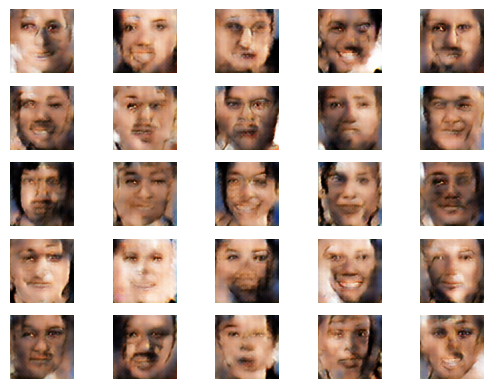

In [ ]:
# load the saved model
model = load_model('/content/drive/MyDrive/exp gan/models/generator_model_128x128_015.h5')
# generate latent vectors to be used as input to the generator
#Here, we are generating 25 latent vectors
latent_points = generate_latent_points(100, 25)
# generate images using the loaded generator model
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1] for plotting
X = (X + 1) / 2.0
# plot the generated images. Let us do 5x5 plot as we generated 25 images
plot_generated(X, 5)


In [ ]:
from numpy import linspace

# Function to generate random latent points
#Same as defined above, re-defining for convenience.
def generate_latent_points(latent_dim, n_samples, n_classes=10):
 	# generate points in the latent space
 	x_input = randn(latent_dim * n_samples)
 	z_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator.
 	return z_input

# Interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
 	# interpolate between points (e.g., between 0 and 1 if you divde to 10 then you have 0.111, 0.222, etc.)
 	ratios = linspace(0, 1, num=n_steps)
 	# linear interpolation of vectors based on the above interpolation ratios
 	vectors = list()
 	for ratio in ratios:
         v = (1.0 - ratio) * p1 + ratio * p2
         vectors.append(v)
 	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
 	# plot images
 	for i in range(n):
         plt.subplot(1, n, 1 + i)
         plt.axis('off')
         plt.imshow(examples[i, :, :])
 	plt.show()

1/1 [==============================] - 1s 1s/step


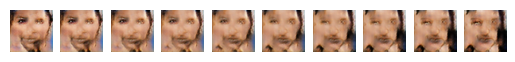

In [ ]:
# load the model, if you haven't already loaded it above.
model = load_model('/content/drive/MyDrive/exp gan/models/generator_model_128x128_015.h5')
# generate points in latent space
#Let us generate 2 latent points between which we will interpolate
pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images using the interpolated latent points
X = model.predict(interpolated)
# scale from [-1,1] to [0,1] for plotting
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))


In [ ]:
from numpy import mean, expand_dims
# example of loading the generator model and generating images

# Function to generate random latent points
#Same as defined above, re-defining for convenience.
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim) #Reshape to be provided as input to the generator.
	return z_input

# create a plot of generated images and save for easy visualization
def plot_generated(examples, n):
    plt.figure(figsize=(16, 16))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :])
    plt.savefig('generated_faces.png')
    plt.close()

4/4 [==============================] - 13s 3s/step


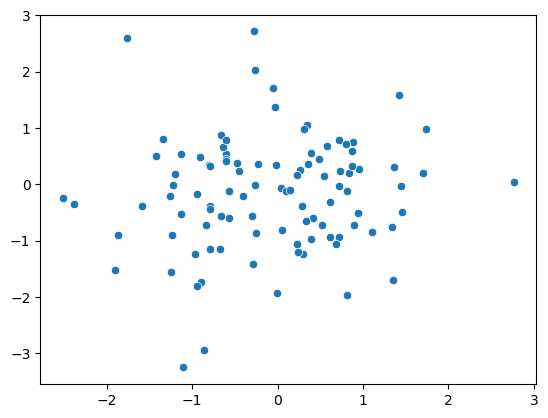

In [ ]:
# load the model
model = load_model('/content/drive/MyDrive/exp gan/models/generator_model_128x128_015.h5')

# generate points in latent space that we can use to generate some images
#We then identify some images with our features of interest and locate thir corresponding latent vectors
latent_points = generate_latent_points(100, 100)

#Plot the latent points to see that they are spread around and we have no clue how to interpret them.
import seaborn as sns
sns.scatterplot(x=latent_points[0],y= latent_points[1])

# generate images using the latent points.
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1] for plotting
X = (X + 1) / 2.0
# plot and save generated images
plot_generated(X, 10)

1/1 [==============================] - 0s 202ms/step


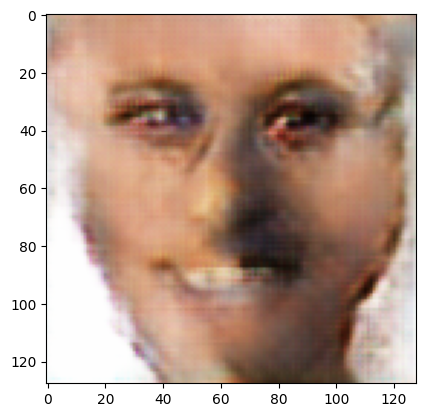

In [ ]:
#Now, identify images corresponding to a specific type.
#e.g. all baby face images, smiling man images,
# smiling man - neutral man + baby face = smiling baby


#Identify a few images from classes of interest

White_smile_person = [12,24,40,]
white_normal_person = [4, 7, 8]
black_normal_person = [9, 13, 14, 17]

#Reassign classes of interest to new variables... just to make it easy not
# to change names all the time we get interested in new features.
feature1_ix = White_smile_person
feature2_ix = white_normal_person
feature3_ix = black_normal_person

# Function to average list of latent space vectors to get the mean for a given type
def average_points(points, ix):
	# subtract 1 from image index so it matches the image from the array
    # we are doing this as our array starts at 0 but we started counting at 1.
	zero_ix = [i-1 for i in ix]
	# retrieve required vectors corresponding to the selected images
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)

	return avg_vector

# average vectors for each class
feature1 = average_points(latent_points, feature1_ix)
feature2 = average_points(latent_points, feature2_ix)
feature3 = average_points(latent_points, feature3_ix)

# Vector arithmetic....
result_vector = feature1 - feature2 + feature3

# generate image using the new calculated vector
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)

# scale pixel values for plotting
result_image = (result_image + 1) / 2.0
plt.imshow(result_image[0])
plt.show()